# **Libraries**


In [ ]:
import pandas as pd
import collections
import spacy

import nltk

nltk.download("all", quiet=True)
from nltk.corpus import stopwords
from nltk import word_tokenize
import string
from nltk.stem import WordNetLemmatizer

import wordcloud
import matplotlib.pyplot as plt

# **Reading Data**


In [49]:
raw_data = pd.read_csv("../data/raw_data.csv")
raw_data.head()

,element_id,site_id,seller_id,Dominio_normalizado,Titulo,Marca,Precio,Rule,Score,Total,Moderado,Fake,Rollback,FK_TEST1,FK_TEST2
0,ARG1000130348,ARGENTINA,924394736,COMPUTER_PROCESSORS,Microprocesador Intel Core I3 12100 12mb Bx807...,Intel,222599.0,NaN,0.11,1,0,0,0,0,0
1,ARG1002056504,ARGENTINA,60385780,COMPUTER_MONITORS,Monitor Gamer Samsung Con Pantalla De 25 60hz...,Samsung,767000.0,NaN,0.29,1,0,0,0,0,0
2,ARG1002630435,ARGENTINA,1085316688,SUNGLASSES,Anteojos De Sol Polarizados Ray-ban Erika Clas...,Ray-Ban,246510.0,NaN,0.51,1,0,0,0,0,0
3,ARG1003499360,ARGENTINA,189266308,HARD_DRIVES_AND_SSDS,Ssd Externo Kingston Xs1000 1tb Negro Usb 3.2 ...,Kingston,179999.0,NaN,0.32,1,0,0,0,0,0
4,ARG1004623658,ARGENTINA,127503700,RAM_MEMORY_MODULES,Memoria Ram Valueram Color Verde 8gb 1 Kingsto...,Kingston,22399.0,NaN,0.80,1,0,0,0,0,0


# **Quick Data Understanding**


Data Types


In [50]:
raw_data.dtypes

element_id              object
site_id                 object
seller_id                int64
Dominio_normalizado     object
Titulo                  object
Marca                   object
Precio                 float64
Rule                    object
Score                  float64
Total                    int64
Moderado                 int64
Fake                     int64
Rollback                 int64
FK_TEST1                 int64
FK_TEST2                 int64
dtype: object

Duplicated Vaues


In [51]:
raw_data.duplicated().sum()

0

Nulls


In [52]:
raw_data.isna().sum()
pd.DataFrame(raw_data.isna().sum() / len(raw_data) * 100).sort_values(
    0, ascending=False
)

,0
Rule,89.403547
element_id,0.000000
site_id,0.000000
seller_id,0.000000
Dominio_normalizado,0.000000
Titulo,0.000000
Marca,0.000000
Precio,0.000000
Score,0.000000
Total,0.000000


Review Some Distributions


In [53]:
raw_data.describe()

,seller_id,Precio,Score,Total,Moderado,Fake,Rollback,FK_TEST1,FK_TEST2
count,4.037200e+04,4.037200e+04,40372.000000,40372.0,40372.000000,40372.000000,40372.000000,40372.000000,40372.000000
mean,1.911603e+09,2.455866e+05,0.428654,1.0,0.105965,0.111191,0.007580,0.047483,0.007282
std,1.784332e+09,6.435465e+05,0.330362,0.0,0.307796,0.314372,0.086731,0.212673,0.085026
min,4.281520e+05,1.117000e+01,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.440346e+08,6.767050e+02,0.150000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.217641e+09,4.299000e+03,0.310000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.609587e+09,1.549900e+05,0.810000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.880437e+09,1.289990e+07,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


# **Building Final Dataset**


In [54]:
process_data = raw_data.copy()
process_data["Rule"] = process_data["Rule"].fillna("NOT_MODERATED")
process_data

,element_id,site_id,seller_id,Dominio_normalizado,Titulo,Marca,Precio,Rule,Score,Total,Moderado,Fake,Rollback,FK_TEST1,FK_TEST2
0,ARG1000130348,ARGENTINA,924394736,COMPUTER_PROCESSORS,Microprocesador Intel Core I3 12100 12mb Bx807...,Intel,222599.0,NOT_MODERATED,0.11,1,0,0,0,0,0
1,ARG1002056504,ARGENTINA,60385780,COMPUTER_MONITORS,Monitor Gamer Samsung Con Pantalla De 25 60hz...,Samsung,767000.0,NOT_MODERATED,0.29,1,0,0,0,0,0
2,ARG1002630435,ARGENTINA,1085316688,SUNGLASSES,Anteojos De Sol Polarizados Ray-ban Erika Clas...,Ray-Ban,246510.0,NOT_MODERATED,0.51,1,0,0,0,0,0
3,ARG1003499360,ARGENTINA,189266308,HARD_DRIVES_AND_SSDS,Ssd Externo Kingston Xs1000 1tb Negro Usb 3.2 ...,Kingston,179999.0,NOT_MODERATED,0.32,1,0,0,0,0,0
4,ARG1004623658,ARGENTINA,127503700,RAM_MEMORY_MODULES,Memoria Ram Valueram Color Verde 8gb 1 Kingsto...,Kingston,22399.0,NOT_MODERATED,0.80,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40367,PER9979201495,PERU,1906413812,SPEAKERS,Bocina Jbl Charge 5 Jblcharge5 Portátil Con Bl...,JBL,799.0,NOT_MODERATED,0.13,1,0,0,0,0,0
40368,PER9979619481,PERU,699068980,HEADPHONES,Audifonos Jbl Tune 520 Bt Bluetooth On Ear Col...,JBL,299.0,NOT_MODERATED,0.80,1,0,0,0,0,0
40369,PER9980515950,PERU,1510316564,SMARTWATCHES,Apple Watch Series 10 Gps Caja De Aluminio Ne...,Apple,2499.0,NOT_MODERATED,0.83,1,0,0,0,0,0
40370,PER999421010,PERU,2495083952,WRISTWATCHES,Reloj Casio W218wd Acero Inoxidable Alarma Sum...,Casio,389.0,NOT_MODERATED,0.10,1,0,0,0,0,0


In [55]:
process_data.to_csv("../data/processed_data.csv", index=False)

# **Building Text Dataset**


Normalizing Data


In [ ]:
def preprocess(text: str, language: str) -> tuple:
    stop_words = set(stopwords.words(language))
    wordnet_lemmatizer = WordNetLemmatizer()
    text = text.lower()
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    lemas = [wordnet_lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(lemas), len(lemas)


text_brasil = (
    process_data[process_data["site_id"] == "BRASIL"]["Titulo"]
    .apply(lambda x: preprocess(x, "portuguese"))
    .apply(pd.Series)
    .rename(columns={0: "normalized", 1: "number_of_words"})
)
text_spanish = (
    process_data[process_data["site_id"] != "BRASIL"]["Titulo"]
    .apply(lambda x: preprocess(x, "spanish"))
    .apply(pd.Series)
    .rename(columns={0: "normalized", 1: "number_of_words"})
)
text_all_countries = pd.concat([text_spanish, text_brasil], axis=0).sort_index()
df_raw_text = pd.concat([process_data, text_all_countries], axis=1)

In [59]:
df_raw_text.head()

,element_id,site_id,seller_id,Dominio_normalizado,Titulo,Marca,Precio,Rule,Score,Total,Moderado,Fake,Rollback,FK_TEST1,FK_TEST2,normalized,number_of_words
0,ARG1000130348,ARGENTINA,924394736,COMPUTER_PROCESSORS,Microprocesador Intel Core I3 12100 12mb Bx807...,Intel,222599.0,NOT_MODERATED,0.11,1,0,0,0,0,0,microprocesador intel core i3 12100 12mb bx807...,23
1,ARG1002056504,ARGENTINA,60385780,COMPUTER_MONITORS,Monitor Gamer Samsung Con Pantalla De 25 60hz...,Samsung,767000.0,NOT_MODERATED,0.29,1,0,0,0,0,0,monitor gamer samsung pantalla 25 60hz 220v re...,10
2,ARG1002630435,ARGENTINA,1085316688,SUNGLASSES,Anteojos De Sol Polarizados Ray-ban Erika Clas...,Ray-Ban,246510.0,NOT_MODERATED,0.51,1,0,0,0,0,0,anteojos sol polarizados rayban erika classic ...,13
3,ARG1003499360,ARGENTINA,189266308,HARD_DRIVES_AND_SSDS,Ssd Externo Kingston Xs1000 1tb Negro Usb 3.2 ...,Kingston,179999.0,NOT_MODERATED,0.32,1,0,0,0,0,0,ssd externo kingston xs1000 1tb negro usb 32 g...,10
4,ARG1004623658,ARGENTINA,127503700,RAM_MEMORY_MODULES,Memoria Ram Valueram Color Verde 8gb 1 Kingsto...,Kingston,22399.0,NOT_MODERATED,0.80,1,0,0,0,0,0,memoria ram valueram color verde 8gb 1 kingsto...,9


# **Functions**


In [124]:
def most_important_no_stops(text: str) -> str:
    frequencies = dict(collections.Counter(text.split(" ")))
    return max(frequencies, key=frequencies.get)


def n_most_important_no_stops(text: str, n: int) -> list[str]:
    frequencies = dict(
        sorted(
            collections.Counter(text.split(" ")).items(),
            key=lambda item: item[1],
            reverse=True,
        )
    )
    return list(frequencies.keys())[:n]


def n_most_important_bigrams(text: str, n: int) -> list[str]:
    tokens = nltk.word_tokenize(text)
    bigrams = list(nltk.bigrams(tokens))
    filtered_bigrams = [
        bigram
        for bigram in bigrams
        if len(bigram[0]) > 1
        and len(bigram[1]) > 1
        and len(bigram[0]) + len(bigram[1]) > 5
    ]
    frequencies_bigrams = dict(
        sorted(
            collections.Counter(filtered_bigrams).items(),
            key=lambda x: x[1],
            reverse=True,
        )
    )
    return list(frequencies_bigrams.keys())[:n]

# **Country Analysis**


## _Total Analysis_


In [94]:
df_country_total = (
    df_raw_text.groupby(["site_id"])
    .agg(
        {
            "Titulo": lambda x: " ".join(x),
            "normalized": lambda x: " ".join(x),
            "seller_id": pd.Series.nunique,
            "Dominio_normalizado": pd.Series.nunique,
            "element_id": "count",
            "Marca": pd.Series.nunique,
            "Precio": [
                ("min", "min"),
                ("percentile25", lambda x: x.quantile(0.25)),
                ("mean", "mean"),
                ("median", "median"),
                ("percentile75", lambda x: x.quantile(0.75)),
                ("max", "max"),
            ],
            "number_of_words": [
                ("min", "min"),
                ("percentile25", lambda x: x.quantile(0.25)),
                ("mean", "mean"),
                ("median", "median"),
                ("percentile75", lambda x: x.quantile(0.75)),
                ("max", "max"),
            ],
        }
    )
    .reset_index()
)
df_country_total.columns = [
    "_".join(col).strip() for col in df_country_total.columns.values
]
df_country_total = df_country_total.rename(
    columns={
        "site_id_": "site_id",
        "Titulo_<lambda>": "titles",
        "normalized_<lambda>": "normalize",
        "seller_id_nunique": "num_sellers",
        "Dominio_normalizado_nunique": "num_dominio_normalizado",
        "element_id_count": "num_elements",
        "Marca_nunique": "num_marca",
        "Precio_mean": "mean_price",
        "Precio_percentile25": "percentile25_price",
        "Precio_percentile75": "percentile75_price",
        "Precio_median": "median_price",
        "Precio_min": "min_price",
        "Precio_max": "max_price",
        "number_of_words_mean": "mean_number_of_words",
        "number_of_words_min": "min_number_of_words",
        "number_of_words_max": "max_number_of_words",
        "number_of_words_percentile75": "percentile75_number_of_words",
        "number_of_words_percentile25": "percentile25_number_of_words",
        "number_of_words_median": "median_number_of_words",
    }
)
tk = nltk.TweetTokenizer()
df_country_total["tokens"] = df_country_total["titles"].apply(tk.tokenize)
df_country_total

,site_id,titles,normalize,num_sellers,num_dominio_normalizado,num_elements,num_marca,min_price,percentile25_price,mean_price,median_price,percentile75_price,max_price,min_number_of_words,percentile25_number_of_words,mean_number_of_words,median_number_of_words,percentile75_number_of_words,max_number_of_words,tokens
0,ARGENTINA,Microprocesador Intel Core I3 12100 12mb Bx807...,microprocesador intel core i3 12100 12mb bx807...,279,27,11938,43,3499.50,90000.000,609388.477741,248050.000,795999.7500,9663619.0,3,8.0,12.256576,10.0,13.0,39,"[Microprocesador, Intel, Core, I3, 12100, 12mb..."
1,BRASIL,Cartão De Memória Kingston Sds2-64gb Canvas Se...,cartão memória kingston sds264gb canvas select...,394,27,14142,48,11.17,231.340,1348.618944,593.675,1238.9975,23999.0,3,7.0,9.832273,9.0,11.0,26,"[Cartão, De, Memória, Kingston, Sds, 2-64, gb,..."
2,CHILE,Tóner Hp 206a Color Cian Tarjeta De Memoria Cf...,tóner hp 206a color cian tarjeta memoria cfexp...,83,26,2116,28,2860.50,33990.000,260282.366257,89990.000,255240.0000,5249990.0,2,7.0,8.956049,9.0,11.0,25,"[Tóner, Hp, 206a, Color, Cian, Tarjeta, De, Me..."
3,COLOMBIA,Samsung Galaxy A05s Dual Sim 128 Gb Plateado 4...,samsung galaxy a05s dual sim 128 gb plateado 4...,38,24,2044,22,19900.00,299937.500,988805.057241,605250.000,952000.0000,12899900.0,2,7.0,10.043053,10.0,12.0,30,"[Samsung, Galaxy, A05s, Dual, Sim, 128, Gb, Pl..."
4,MEXICO,Lentes Sol Carolina Herrera Mujer Her 0177/s 2...,lentes sol carolina herrera mujer her 0177s 20...,283,27,8378,36,35.55,1078.505,5636.939949,2510.500,6498.7500,161499.0,2,7.0,10.055980,9.0,12.0,35,"[Lentes, Sol, Carolina, Herrera, Mujer, Her, 0..."
5,PERU,Apple AirPods Max - Morado - Distribuidor Auto...,apple airpods max morado distribuidor autoriza...,61,26,1754,27,14.95,169.165,1009.432691,359.000,1013.8325,16827.0,3,7.0,9.127708,9.0,11.0,34,"[Apple, AirPods, Max, -, Morado, -, Distribuid..."


In [95]:
df_country_total["most_important_word"] = df_country_total["normalize"].apply(
    lambda text: most_important_no_stops(text)
)
df_country_total["10_most_important_words"] = df_country_total["normalize"].apply(
    lambda text: n_most_important_no_stops(text, 10)
)
df_country_total["10_more_important_bigrams"] = df_country_total["titles"].apply(
    lambda text: n_most_important_bigrams(text, 10)
)
df_country_total["lexical_richness"] = df_country_total["titles"].apply(
    lambda tokens: len(set(tokens)) / len(tokens)
)
df_country_total

,site_id,titles,normalize,num_sellers,num_dominio_normalizado,num_elements,num_marca,min_price,percentile25_price,mean_price,...,percentile25_number_of_words,mean_number_of_words,median_number_of_words,percentile75_number_of_words,max_number_of_words,tokens,most_important_word,10_most_important_words,10_more_important_bigrams,lexical_richness
0,ARGENTINA,Microprocesador Intel Core I3 12100 12mb Bx807...,microprocesador intel core i3 12100 12mb bx807...,279,27,11938,43,3499.50,90000.000,609388.477741,...,8.0,12.256576,10.0,13.0,39,"[Microprocesador, Intel, Core, I3, 12100, 12mb...",color,"[color, ram, negro, ssd, notebook, gb, intel, ...","[(Notebook, Lenovo), (Intel, Core), (Color, Ne...",0.000111
1,BRASIL,Cartão De Memória Kingston Sds2-64gb Canvas Se...,cartão memória kingston sds264gb canvas select...,394,27,14142,48,11.17,231.340,1348.618944,...,7.0,9.832273,9.0,11.0,26,"[Cartão, De, Memória, Kingston, Sds, 2-64, gb,...",preto,"[preto, cor, cartão, memória, sandisk, jbl, ca...","[(Cartão, De), (De, Memória), (Relógio, Casio)...",0.000112
2,CHILE,Tóner Hp 206a Color Cian Tarjeta De Memoria Cf...,tóner hp 206a color cian tarjeta memoria cfexp...,83,26,2116,28,2860.50,33990.000,260282.366257,...,7.0,8.956049,9.0,11.0,25,"[Tóner, Hp, 206a, Color, Cian, Tarjeta, De, Me...",color,"[color, negro, reloj, casio, gb, hp, ram, xiao...","[(Color, Negro), (Reloj, Casio), (Color, De), ...",0.000715
3,COLOMBIA,Samsung Galaxy A05s Dual Sim 128 Gb Plateado 4...,samsung galaxy a05s dual sim 128 gb plateado 4...,38,24,2044,22,19900.00,299937.500,988805.057241,...,7.0,10.043053,10.0,12.0,30,"[Samsung, Galaxy, A05s, Dual, Sim, 128, Gb, Pl...",color,"[color, reloj, negro, casio, correa, fondo, ho...","[(Color, Del), (Reloj, Casio), (Color, De), (L...",0.000614
4,MEXICO,Lentes Sol Carolina Herrera Mujer Her 0177/s 2...,lentes sol carolina herrera mujer her 0177s 20...,283,27,8378,36,35.55,1078.505,5636.939949,...,7.0,10.055980,9.0,12.0,35,"[Lentes, Sol, Carolina, Herrera, Mujer, Her, 0...",color,"[color, negro, gb, ram, reloj, hp, casio, corr...","[(Reloj, Casio), (Color, Del), (Color, De), (C...",0.000180
5,PERU,Apple AirPods Max - Morado - Distribuidor Auto...,apple airpods max morado distribuidor autoriza...,61,26,1754,27,14.95,169.165,1009.432691,...,7.0,9.127708,9.0,11.0,34,"[Apple, AirPods, Max, -, Morado, -, Distribuid...",color,"[color, negro, reloj, casio, jbl, bluetooth, k...","[(Color, Negro), (Reloj, Casio), (Con, Bluetoo...",0.000832


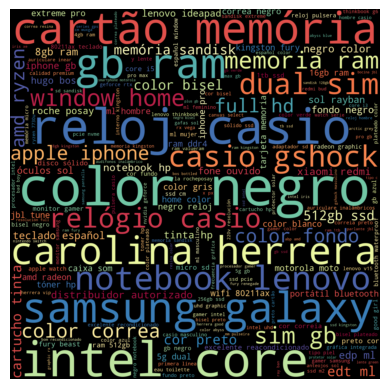

In [96]:
tokens_no_stop_pop = " ".join(df_country_total["normalize"]).split(" ")
text_pop = df_country_total["titles"]
wc = wordcloud.WordCloud(width=1500, height=1500, colormap="Spectral")
wc.generate(" ".join(tokens_no_stop_pop))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")

## _Only Fakes_


In [97]:
df_raw_text_fake = df_raw_text[df_raw_text["Fake"] == 1].copy()
df_country_fake = (
    df_raw_text_fake.groupby(["site_id"])
    .agg(
        {
            "Titulo": lambda x: " ".join(x),
            "normalized": lambda x: " ".join(x),
            "seller_id": pd.Series.nunique,
            "Dominio_normalizado": pd.Series.nunique,
            "element_id": "count",
            "Marca": pd.Series.nunique,
            "Precio": [
                ("min", "min"),
                ("percentile25", lambda x: x.quantile(0.25)),
                ("mean", "mean"),
                ("median", "median"),
                ("percentile75", lambda x: x.quantile(0.75)),
                ("max", "max"),
            ],
            "number_of_words": [
                ("min", "min"),
                ("percentile25", lambda x: x.quantile(0.25)),
                ("mean", "mean"),
                ("median", "median"),
                ("percentile75", lambda x: x.quantile(0.75)),
                ("max", "max"),
            ],
        }
    )
    .reset_index()
)
df_country_fake.columns = [
    "_".join(col).strip() for col in df_country_fake.columns.values
]
df_country_fake = df_country_fake.rename(
    columns={
        "site_id_": "site_id",
        "Titulo_<lambda>": "titles",
        "normalized_<lambda>": "normalize",
        "seller_id_nunique": "num_sellers",
        "Dominio_normalizado_nunique": "num_dominio_normalizado",
        "element_id_count": "num_elements",
        "Marca_nunique": "num_marca",
        "Precio_mean": "mean_price",
        "Precio_percentile25": "percentile25_price",
        "Precio_percentile75": "percentile75_price",
        "Precio_median": "median_price",
        "Precio_min": "min_price",
        "Precio_max": "max_price",
        "number_of_words_mean": "mean_number_of_words",
        "number_of_words_min": "min_number_of_words",
        "number_of_words_max": "max_number_of_words",
        "number_of_words_percentile75": "percentile75_number_of_words",
        "number_of_words_percentile25": "percentile25_number_of_words",
        "number_of_words_median": "median_number_of_words",
    }
)
tk = nltk.TweetTokenizer()
df_country_fake["tokens"] = df_country_fake["titles"].apply(tk.tokenize)
df_country_fake

,site_id,titles,normalize,num_sellers,num_dominio_normalizado,num_elements,num_marca,min_price,percentile25_price,mean_price,median_price,percentile75_price,max_price,min_number_of_words,percentile25_number_of_words,mean_number_of_words,median_number_of_words,percentile75_number_of_words,max_number_of_words,tokens
0,ARGENTINA,Parlante Xiaomi Sound Outdoor Mdz-38-db Portát...,parlante xiaomi sound outdoor mdz38db portátil...,188,25,1352,42,3499.50,57468.375,425658.246664,157877.500,547011.875,7861519.00,4,8.0,12.468935,10.0,13.0,39,"[Parlante, Xiaomi, Sound, Outdoor, Mdz, -, 38,..."
1,BRASIL,Fone De Ouvido Bluetooth Jbl Tune 520bt Blueto...,fone ouvido bluetooth jbl tune 520bt bluetooth...,223,26,1585,48,11.17,149.130,979.446315,370.000,892.850,14443.20,3,8.0,10.246688,9.0,12.0,25,"[Fone, De, Ouvido, Bluetooth, Jbl, Tune, 520bt..."
2,CHILE,Auricular Hp Dhh-1111 In Ear Con Microfono Bál...,auricular hp dhh1111 in ear microfono bálsamo ...,46,21,225,26,2860.50,23495.000,141651.724444,59990.000,159990.000,1399990.00,3,7.0,9.408889,9.0,11.0,22,"[Auricular, Hp, Dhh, -, 1111, In, Ear, Con, Mi..."
3,COLOMBIA,Samsung Galaxy A05s Dual Sim 128 Gb Plateado 4...,samsung galaxy a05s dual sim 128 gb plateado 4...,29,21,205,21,22418.00,213500.000,632691.385366,376100.000,694000.000,7999950.00,4,8.0,10.463415,10.0,12.0,30,"[Samsung, Galaxy, A05s, Dual, Sim, 128, Gb, Pl..."
4,MEXICO,Disco Sólido Ssd Interno Kingston Skc3000d/204...,disco sólido ssd interno kingston skc3000d2048...,173,26,892,36,35.55,699.000,3846.359249,1632.000,4476.555,42199.00,4,8.0,10.596413,10.0,12.0,35,"[Disco, Sólido, Ssd, Interno, Kingston, Skc, 3..."
5,PERU,Kingston Kc3000 M.2 2280 Pcie 4.0 Nvme Velocid...,kingston kc3000 m2 2280 pcie 40 nvme velocidad...,46,20,230,25,14.95,115.625,572.004522,231.655,538.535,6930.69,4,7.0,9.547826,9.0,11.0,25,"[Kingston, Kc3000, M, ., 2, 2280, Pcie, 4.0, N..."


In [98]:
df_country_fake["most_important_word"] = df_country_fake["normalize"].apply(
    lambda text: most_important_no_stops(text)
)
df_country_fake["10_most_important_words"] = df_country_fake["normalize"].apply(
    lambda text: n_most_important_no_stops(text, 10)
)
df_country_fake["10_more_important_bigrams"] = df_country_fake["titles"].apply(
    lambda text: n_most_important_bigrams(text, 10)
)
df_country_fake["lexical_richness"] = df_country_fake["titles"].apply(
    lambda tokens: len(set(tokens)) / len(tokens)
)
df_country_fake

,site_id,titles,normalize,num_sellers,num_dominio_normalizado,num_elements,num_marca,min_price,percentile25_price,mean_price,...,percentile25_number_of_words,mean_number_of_words,median_number_of_words,percentile75_number_of_words,max_number_of_words,tokens,most_important_word,10_most_important_words,10_more_important_bigrams,lexical_richness
0,ARGENTINA,Parlante Xiaomi Sound Outdoor Mdz-38-db Portát...,parlante xiaomi sound outdoor mdz38db portátil...,188,25,1352,42,3499.50,57468.375,425658.246664,...,8.0,12.468935,10.0,13.0,39,"[Parlante, Xiaomi, Sound, Outdoor, Mdz, -, 38,...",color,"[color, ram, negro, ssd, notebook, intel, hp, ...","[(Notebook, Lenovo), (Color, Negro), (Intel, C...",0.000849
1,BRASIL,Fone De Ouvido Bluetooth Jbl Tune 520bt Blueto...,fone ouvido bluetooth jbl tune 520bt bluetooth...,223,26,1585,48,11.17,149.130,979.446315,...,8.0,10.246688,9.0,12.0,25,"[Fone, De, Ouvido, Bluetooth, Jbl, Tune, 520bt...",preto,"[preto, cor, cartão, sandisk, memória, jbl, gb...","[(Cartão, De), (De, Memória), (Calidad, premiu...",0.000887
2,CHILE,Auricular Hp Dhh-1111 In Ear Con Microfono Bál...,auricular hp dhh1111 in ear microfono bálsamo ...,46,21,225,26,2860.50,23495.000,141651.724444,...,7.0,9.408889,9.0,11.0,22,"[Auricular, Hp, Dhh, -, 1111, In, Ear, Con, Mi...",color,"[color, negro, reloj, casio, gb, ram, xiaomi, ...","[(Reloj, Casio), (Color, Negro), (Calidad, pre...",0.005530
3,COLOMBIA,Samsung Galaxy A05s Dual Sim 128 Gb Plateado 4...,samsung galaxy a05s dual sim 128 gb plateado 4...,29,21,205,21,22418.00,213500.000,632691.385366,...,8.0,10.463415,10.0,12.0,30,"[Samsung, Galaxy, A05s, Dual, Sim, 128, Gb, Pl...",color,"[color, reloj, casio, negro, correa, fondo, ho...","[(Color, Del), (Reloj, Casio), (Color, De), (L...",0.005208
4,MEXICO,Disco Sólido Ssd Interno Kingston Skc3000d/204...,disco sólido ssd interno kingston skc3000d2048...,173,26,892,36,35.55,699.000,3846.359249,...,8.0,10.596413,10.0,12.0,35,"[Disco, Sólido, Ssd, Interno, Kingston, Skc, 3...",color,"[color, negro, gb, ram, hp, reloj, correa, cas...","[(Color, Del), (Reloj, Casio), (Color, De), (P...",0.001394
5,PERU,Kingston Kc3000 M.2 2280 Pcie 4.0 Nvme Velocid...,kingston kc3000 m2 2280 pcie 40 nvme velocidad...,46,20,230,25,14.95,115.625,572.004522,...,7.0,9.547826,9.0,11.0,25,"[Kingston, Kc3000, M, ., 2, 2280, Pcie, 4.0, N...",color,"[color, negro, reloj, casio, imitacion, jbl, o...","[(Color, Negro), (Reloj, Casio), (Color, Del),...",0.005513


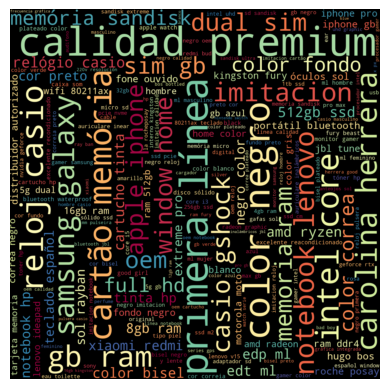

In [99]:
tokens_no_stop_pop = " ".join(df_country_fake["normalize"]).split(" ")
text_pop = df_country_fake["titles"]
wc = wordcloud.WordCloud(width=1500, height=1500, colormap="Spectral")
wc.generate(" ".join(tokens_no_stop_pop))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")

## _No Fake_


In [106]:
df_raw_text_fake = df_raw_text[df_raw_text["Fake"] == 0].copy()
df_country_not_fake = (
    df_raw_text_fake.groupby(["site_id"])
    .agg(
        {
            "Titulo": lambda x: " ".join(x),
            "normalized": lambda x: " ".join(x),
            "seller_id": pd.Series.nunique,
            "Dominio_normalizado": pd.Series.nunique,
            "element_id": "count",
            "Marca": pd.Series.nunique,
            "Precio": [
                ("min", "min"),
                ("percentile25", lambda x: x.quantile(0.25)),
                ("mean", "mean"),
                ("median", "median"),
                ("percentile75", lambda x: x.quantile(0.75)),
                ("max", "max"),
            ],
            "number_of_words": [
                ("min", "min"),
                ("percentile25", lambda x: x.quantile(0.25)),
                ("mean", "mean"),
                ("median", "median"),
                ("percentile75", lambda x: x.quantile(0.75)),
                ("max", "max"),
            ],
        }
    )
    .reset_index()
)
df_country_not_fake.columns = [
    "_".join(col).strip() for col in df_country_not_fake.columns.values
]
df_country_not_fake = df_country_not_fake.rename(
    columns={
        "site_id_": "site_id",
        "Titulo_<lambda>": "titles",
        "normalized_<lambda>": "normalize",
        "seller_id_nunique": "num_sellers",
        "Dominio_normalizado_nunique": "num_dominio_normalizado",
        "element_id_count": "num_elements",
        "Marca_nunique": "num_marca",
        "Precio_mean": "mean_price",
        "Precio_percentile25": "percentile25_price",
        "Precio_percentile75": "percentile75_price",
        "Precio_median": "median_price",
        "Precio_min": "min_price",
        "Precio_max": "max_price",
        "number_of_words_mean": "mean_number_of_words",
        "number_of_words_min": "min_number_of_words",
        "number_of_words_max": "max_number_of_words",
        "number_of_words_percentile75": "percentile75_number_of_words",
        "number_of_words_percentile25": "percentile25_number_of_words",
        "number_of_words_median": "median_number_of_words",
    }
)
tk = nltk.TweetTokenizer()
df_country_not_fake["tokens"] = df_country_not_fake["titles"].apply(tk.tokenize)
df_country_not_fake

,site_id,titles,normalize,num_sellers,num_dominio_normalizado,num_elements,num_marca,min_price,percentile25_price,mean_price,median_price,percentile75_price,max_price,min_number_of_words,percentile25_number_of_words,mean_number_of_words,median_number_of_words,percentile75_number_of_words,max_number_of_words,tokens
0,ARGENTINA,Microprocesador Intel Core I3 12100 12mb Bx807...,microprocesador intel core i3 12100 12mb bx807...,273,27,10586,19,3899.0,96238.00,6.328537e+05,255189.00,844999.00,9663619.0,3,8.0,12.229454,10.0,13.0,37,"[Microprocesador, Intel, Core, I3, 12100, 12mb..."
1,BRASIL,Cartão De Memória Kingston Sds2-64gb Canvas Se...,cartão memória kingston sds264gb canvas select...,388,27,12557,19,12.9,248.00,1.395218e+03,621.84,1289.00,23999.0,3,7.0,9.779963,9.0,11.0,26,"[Cartão, De, Memória, Kingston, Sds, 2-64, gb,..."
2,CHILE,Tóner Hp 206a Color Cian Tarjeta De Memoria Cf...,tóner hp 206a color cian tarjeta memoria cfexp...,81,26,1891,18,2864.0,34990.00,2.743976e+05,92990.00,276121.00,5249990.0,2,7.0,8.902168,9.0,10.5,25,"[Tóner, Hp, 206a, Color, Cian, Tarjeta, De, Me..."
3,COLOMBIA,Reloj Casio Hombre F-94wa-9dg Core Mens Gafas ...,reloj casio hombre f94wa9dg core men gafas sol...,38,24,1839,17,19900.0,313800.00,1.028502e+06,642215.00,979850.00,12899900.0,2,7.0,9.996194,10.0,12.0,27,"[Reloj, Casio, Hombre, F, -, 94wa, -, 9dg, Cor..."
4,MEXICO,Lentes Sol Carolina Herrera Mujer Her 0177/s 2...,lentes sol carolina herrera mujer her 0177s 20...,277,27,7486,19,49.0,1129.00,5.850298e+03,2635.00,6845.49,161499.0,2,7.0,9.991584,9.0,12.0,35,"[Lentes, Sol, Carolina, Herrera, Mujer, Her, 0..."
5,PERU,Apple AirPods Max - Morado - Distribuidor Auto...,apple airpods max morado distribuidor autoriza...,61,25,1524,17,18.9,179.46,1.075449e+03,389.00,1151.50,16827.0,3,7.0,9.064304,9.0,10.0,34,"[Apple, AirPods, Max, -, Morado, -, Distribuid..."


In [107]:
df_country_not_fake["most_important_word"] = df_country_not_fake["normalize"].apply(
    lambda text: most_important_no_stops(text)
)
df_country_not_fake["10_most_important_words"] = df_country_not_fake["normalize"].apply(
    lambda text: n_most_important_no_stops(text, 10)
)
df_country_not_fake["10_more_important_bigrams"] = df_country_not_fake["titles"].apply(
    lambda text: n_most_important_bigrams(text, 10)
)
df_country_not_fake["lexical_richness"] = df_country_not_fake["titles"].apply(
    lambda tokens: len(set(tokens)) / len(tokens)
)
df_country_not_fake

,site_id,titles,normalize,num_sellers,num_dominio_normalizado,num_elements,num_marca,min_price,percentile25_price,mean_price,...,percentile25_number_of_words,mean_number_of_words,median_number_of_words,percentile75_number_of_words,max_number_of_words,tokens,most_important_word,10_most_important_words,10_more_important_bigrams,lexical_richness
0,ARGENTINA,Microprocesador Intel Core I3 12100 12mb Bx807...,microprocesador intel core i3 12100 12mb bx807...,273,27,10586,19,3899.0,96238.00,6.328537e+05,...,8.0,12.229454,10.0,13.0,37,"[Microprocesador, Intel, Core, I3, 12100, 12mb...",color,"[color, ram, negro, ssd, notebook, gb, intel, ...","[(Notebook, Lenovo), (Intel, Core), (Color, Ne...",0.000126
1,BRASIL,Cartão De Memória Kingston Sds2-64gb Canvas Se...,cartão memória kingston sds264gb canvas select...,388,27,12557,19,12.9,248.00,1.395218e+03,...,7.0,9.779963,9.0,11.0,26,"[Cartão, De, Memória, Kingston, Sds, 2-64, gb,...",preto,"[preto, cor, cartão, memória, sandisk, jbl, ca...","[(Cartão, De), (De, Memória), (Relógio, Casio)...",0.000126
2,CHILE,Tóner Hp 206a Color Cian Tarjeta De Memoria Cf...,tóner hp 206a color cian tarjeta memoria cfexp...,81,26,1891,18,2864.0,34990.00,2.743976e+05,...,7.0,8.902168,9.0,10.5,25,"[Tóner, Hp, 206a, Color, Cian, Tarjeta, De, Me...",color,"[color, negro, reloj, casio, gb, hp, ram, xiao...","[(Color, Negro), (Reloj, Casio), (Color, De), ...",0.000798
3,COLOMBIA,Reloj Casio Hombre F-94wa-9dg Core Mens Gafas ...,reloj casio hombre f94wa9dg core men gafas sol...,38,24,1839,17,19900.0,313800.00,1.028502e+06,...,7.0,9.996194,10.0,12.0,27,"[Reloj, Casio, Hombre, F, -, 94wa, -, 9dg, Cor...",color,"[color, reloj, negro, casio, correa, fondo, ho...","[(Color, Del), (Reloj, Casio), (Color, De), (L...",0.000685
4,MEXICO,Lentes Sol Carolina Herrera Mujer Her 0177/s 2...,lentes sol carolina herrera mujer her 0177s 20...,277,27,7486,19,49.0,1129.00,5.850298e+03,...,7.0,9.991584,9.0,12.0,35,"[Lentes, Sol, Carolina, Herrera, Mujer, Her, 0...",color,"[color, negro, gb, ram, reloj, hp, casio, corr...","[(Reloj, Casio), (Color, Del), (Color, De), (C...",0.000203
5,PERU,Apple AirPods Max - Morado - Distribuidor Auto...,apple airpods max morado distribuidor autoriza...,61,25,1524,17,18.9,179.46,1.075449e+03,...,7.0,9.064304,9.0,10.0,34,"[Apple, AirPods, Max, -, Morado, -, Distribuid...",color,"[color, negro, reloj, casio, jbl, bluetooth, k...","[(Color, Negro), (Reloj, Casio), (Con, Bluetoo...",0.000956


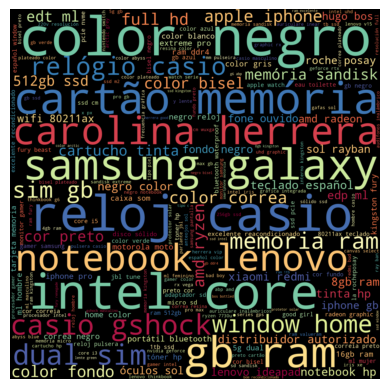

In [108]:
tokens_no_stop_pop = " ".join(df_country_not_fake["normalize"]).split(" ")
text_pop = df_country_not_fake["titles"]
wc = wordcloud.WordCloud(width=1500, height=1500, colormap="Spectral")
wc.generate(" ".join(tokens_no_stop_pop))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")

# **Dominio**

## _Total Analysis_

In [105]:
df_domains_total = (
    df_raw_text.groupby(["Dominio_normalizado"])
    .agg(
        {
            "Titulo": lambda x: " ".join(x),
            "normalized": lambda x: " ".join(x),
            "seller_id": pd.Series.nunique,
            "site_id": pd.Series.nunique,
            "element_id": "count",
            "Marca": pd.Series.nunique,
            "Precio": [
                ("min", "min"),
                ("percentile25", lambda x: x.quantile(0.25)),
                ("mean", "mean"),
                ("median", "median"),
                ("percentile75", lambda x: x.quantile(0.75)),
                ("max", "max"),
            ],
            "number_of_words": [
                ("min", "min"),
                ("percentile25", lambda x: x.quantile(0.25)),
                ("mean", "mean"),
                ("median", "median"),
                ("percentile75", lambda x: x.quantile(0.75)),
                ("max", "max"),
            ],
        }
    )
    .reset_index()
)
df_domains_total.columns = [
    "_".join(col).strip() for col in df_domains_total.columns.values
]
df_domains_total = df_domains_total.rename(
    columns={
        "site_id_": "site_id",
        "Titulo_<lambda>": "titles",
        "normalized_<lambda>": "normalize",
        "seller_id_nunique": "num_sellers",
        "site_id_nunique": "num_countries",
        "element_id_count": "num_elements",
        "Marca_nunique": "num_marca",
        "Precio_mean": "mean_price",
        "Precio_percentile25": "percentile25_price",
        "Precio_percentile75": "percentile75_price",
        "Precio_median": "median_price",
        "Precio_min": "min_price",
        "Precio_max": "max_price",
        "number_of_words_mean": "mean_number_of_words",
        "number_of_words_min": "min_number_of_words",
        "number_of_words_max": "max_number_of_words",
        "number_of_words_percentile75": "percentile75_number_of_words",
        "number_of_words_percentile25": "percentile25_number_of_words",
        "number_of_words_median": "median_number_of_words",
    }
)
tk = nltk.TweetTokenizer()
df_domains_total["tokens"] = df_domains_total["titles"].apply(tk.tokenize)
df_domains_total

,Dominio_normalizado_,titles,normalize,num_sellers,num_countries,num_elements,num_marca,min_price,percentile25_price,mean_price,median_price,percentile75_price,max_price,min_number_of_words,percentile25_number_of_words,mean_number_of_words,median_number_of_words,percentile75_number_of_words,max_number_of_words,tokens
0,AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS,Cable Hdmi A Hdmi 2 Metros 2.0 4k 18gbps Pc No...,cable hdmi hdmi 2 metro 20 4k 18gbps pc notebo...,11,6,16,5,17.45,197.9825,1.091474e+04,2073.960,1.421833e+04,79900.00,4,8.0,9.625000,11.0,11.00,15,"[Cable, Hdmi, A, Hdmi, 2, Metros, 2.0, 4k, 18g..."
1,BODY_SKIN_CARE_PRODUCTS,La Roche Posay Lipikar Gel Lavant X 400 Ml La ...,roche posay lipikar gel lavant x 400 ml roche ...,53,6,184,3,22.95,518.4250,3.356500e+04,26919.100,5.275500e+04,137000.00,4,8.0,9.663043,9.0,10.25,21,"[La, Roche, Posay, Lipikar, Gel, Lavant, X, 40..."
2,CELLPHONES,Samsung Galaxy A15 128 Gb Azul Claro 4 Gb Ram ...,samsung galaxy a15 128 gb azul claro 4 gb ram ...,233,6,5222,13,319.00,2999.0000,2.715481e+05,8999.000,2.832940e+05,11290350.00,4,8.0,10.593642,10.0,12.00,30,"[Samsung, Galaxy, A15, 128, Gb, Azul, Claro, 4..."
3,COMPUTER_MICE,Mouse Lenovo 530 Inalambrico 1200dpi 3 Botones...,mouse lenovo 530 inalambrico 1200dpi 3 botones...,86,6,290,7,19.50,150.1500,2.835478e+04,3633.500,3.743890e+04,475247.00,3,6.0,7.544828,7.0,9.00,14,"[Mouse, Lenovo, 530, Inalambrico, 1200dpi, 3, ..."
4,COMPUTER_MONITORS,Monitor Gamer Samsung Con Pantalla De 25 60hz...,monitor gamer samsung pantalla 25 60hz 220v re...,156,6,1114,10,199.51,3529.1325,5.122131e+05,257527.420,5.987098e+05,9999900.00,3,9.0,10.198384,10.0,11.00,23,"[Monitor, Gamer, Samsung, Con, Pantalla, De, 2..."
5,COMPUTER_PROCESSORS,Microprocesador Intel Core I3 12100 12mb Bx807...,microprocesador intel core i3 12100 12mb bx807...,95,5,966,5,29.90,1997.6575,1.887720e+05,8044.500,2.224915e+05,4069788.36,4,9.0,10.396480,10.0,12.00,23,"[Microprocesador, Intel, Core, I3, 12100, 12mb..."
6,DATA_CABLES_AND_ADAPTERS,Apple Cable Lightning A Usb-c De 1 Metro - Dis...,apple cable lightning usbc 1 metro distribuido...,89,6,257,7,11.17,69.9900,2.652207e+04,3899.000,3.000000e+04,253199.00,3,8.0,9.677043,9.0,11.00,21,"[Apple, Cable, Lightning, A, Usb-c, De, 1, Met..."
7,FACIAL_SKIN_CARE_PRODUCTS,La Roche-posay Crema Mela B3 Fps30+ 40ml Momen...,rocheposay crema mela b3 fps30 40ml momento ap...,73,6,886,3,23.60,364.7500,4.564039e+04,32985.000,8.004825e+04,269456.00,4,7.0,9.806998,9.0,12.00,24,"[La, Roche-posay, Crema, Mela, B3, Fps, 30, +,..."
8,GAMEPADS_AND_JOYSTICKS,Controlador Inalámbrico Sony Dualsense Edge Ps...,controlador inalámbrico sony dualsense edge ps...,42,5,102,4,119.00,489.0000,5.621924e+04,865.750,4.172638e+03,586059.00,4,7.0,7.754902,7.0,8.75,15,"[Controlador, Inalámbrico, Sony, Dualsense, Ed..."
9,HARD_DRIVES_AND_SSDS,Ssd Externo Kingston Xs1000 1tb Negro Usb 3.2 ...,ssd externo kingston xs1000 1tb negro usb 32 g...,158,6,1425,9,105.95,829.0000,1.521918e+05,2999.000,1.512000e+05,7073609.00,3,8.0,10.618947,10.0,12.00,24,"[Ssd, Externo, Kingston, Xs1000, 1tb, Negro, U..."


In [109]:
df_domains_total["most_important_word"] = df_domains_total["normalize"].apply(
    lambda text: most_important_no_stops(text)
)
df_domains_total["10_most_important_words"] = df_domains_total["normalize"].apply(
    lambda text: n_most_important_no_stops(text, 10)
)
df_domains_total["10_more_important_bigrams"] = df_domains_total["titles"].apply(
    lambda text: n_most_important_bigrams(text, 10)
)
df_domains_total["lexical_richness"] = df_domains_total["titles"].apply(
    lambda tokens: len(set(tokens)) / len(tokens)
)
df_domains_total

,Dominio_normalizado_,titles,normalize,num_sellers,num_countries,num_elements,num_marca,min_price,percentile25_price,mean_price,...,percentile25_number_of_words,mean_number_of_words,median_number_of_words,percentile75_number_of_words,max_number_of_words,tokens,most_important_word,10_most_important_words,10_more_important_bigrams,lexical_richness
0,AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS,Cable Hdmi A Hdmi 2 Metros 2.0 4k 18gbps Pc No...,cable hdmi hdmi 2 metro 20 4k 18gbps pc notebo...,11,6,16,5,17.45,197.9825,1.091474e+04,...,8.0,9.625000,11.0,11.00,15,"[Cable, Hdmi, A, Hdmi, 2, Metros, 2.0, 4k, 18g...",hdmi,"[hdmi, cable, hp, 2, metro, 4k, 20, cabo, 1, pc]","[(Cable, Hdmi), (Metros, 2.0), (Pc, Notebook),...",0.062566
1,BODY_SKIN_CARE_PRODUCTS,La Roche Posay Lipikar Gel Lavant X 400 Ml La ...,roche posay lipikar gel lavant x 400 ml roche ...,53,6,184,3,22.95,518.4250,3.356500e+04,...,8.0,9.663043,9.0,10.25,21,"[La, Roche, Posay, Lipikar, Gel, Lavant, X, 40...",lipikar,"[lipikar, rocheposay, baume, hidratante, roche...","[(La, Roche-posay), (La, Roche), (Roche, Posay...",0.005188
2,CELLPHONES,Samsung Galaxy A15 128 Gb Azul Claro 4 Gb Ram ...,samsung galaxy a15 128 gb azul claro 4 gb ram ...,233,6,5222,13,319.00,2999.0000,2.715481e+05,...,8.0,10.593642,10.0,12.00,30,"[Samsung, Galaxy, A15, 128, Gb, Azul, Claro, 4...",gb,"[gb, ram, galaxy, samsung, 128, iphone, 5g, du...","[(Samsung, Galaxy), (Dual, Sim), (Apple, iPhon...",0.000275
3,COMPUTER_MICE,Mouse Lenovo 530 Inalambrico 1200dpi 3 Botones...,mouse lenovo 530 inalambrico 1200dpi 3 botones...,86,6,290,7,19.50,150.1500,2.835478e+04,...,6.0,7.544828,7.0,9.00,14,"[Mouse, Lenovo, 530, Inalambrico, 1200dpi, 3, ...",mouse,"[mouse, hp, negro, color, inalámbrico, lenovo,...","[(Negro, Mouse), (Mouse, Inalámbrico), (Mouse,...",0.005313
4,COMPUTER_MONITORS,Monitor Gamer Samsung Con Pantalla De 25 60hz...,monitor gamer samsung pantalla 25 60hz 220v re...,156,6,1114,10,199.51,3529.1325,5.122131e+05,...,9.0,10.198384,10.0,11.00,23,"[Monitor, Gamer, Samsung, Con, Pantalla, De, 2...",monitor,"[monitor, samsung, gamer, hd, negro, color, fu...","[(Monitor, Gamer), (Full, Hd), (Gamer, Samsung...",0.001105
5,COMPUTER_PROCESSORS,Microprocesador Intel Core I3 12100 12mb Bx807...,microprocesador intel core i3 12100 12mb bx807...,95,5,966,5,29.90,1997.6575,1.887720e+05,...,9.0,10.396480,10.0,12.00,23,"[Microprocesador, Intel, Core, I3, 12100, 12mb...",intel,"[intel, core, núcleos, procesador, frecuencia,...","[(Intel, Core), (De, Frecuencia), (Gráfica, In...",0.000990
6,DATA_CABLES_AND_ADAPTERS,Apple Cable Lightning A Usb-c De 1 Metro - Dis...,apple cable lightning usbc 1 metro distribuido...,89,6,257,7,11.17,69.9900,2.652207e+04,...,8.0,9.677043,9.0,11.00,21,"[Apple, Cable, Lightning, A, Usb-c, De, 1, Met...",usb,"[usb, cable, c, tipo, usbc, cabo, lightning, b...","[(Usb, Tipo), (Distribuidor, Autorizado), (Col...",0.004880
7,FACIAL_SKIN_CARE_PRODUCTS,La Roche-posay Crema Mela B3 Fps30+ 40ml Momen...,rocheposay crema mela b3 fps30 40ml momento ap...,73,6,886,3,23.60,364.7500,4.564039e+04,...,7.0,9.806998,9.0,12.00,24,"[La, Roche-posay, Crema, Mela, B3, Fps, 30, +,...",roche,"[roche, posay, piel, tipo, rocheposay, effacla...","[(La, Roche), (Roche, Posay), (Tipo, De), (La,...",0.001303
8,GAMEPADS_AND_JOYSTICKS,Controlador Inalámbrico Sony Dualsense Edge Ps...,controlador inalámbrico sony dualsense edge ps...,42,5,102,4,119.00,489.0000,5.621924e+04,...,7.0,7.754902,7.0,8.75,15,"[Controlador, Inalámbrico, Sony, Dualsense, Ed...",dualsense,"[dualsense, inalámbrico, playstation, ps5, con...","[(Sem, Fio), (Pro, Controller), (Inalámbrico, ...",0.011334
9,HARD_DRIVES_AND_SSDS,Ssd Externo Kingston Xs1000 1tb Negro Usb 3.2 ...,ssd externo kingston xs1000 1tb negro usb 32 g...,158,6,1425,9,105.95,829.0000,1.521918e+05,...,8.0,10.618947,10.0,12.00,24,"[Ssd, Externo, Kingston, Xs1000, 1tb, Negro, U...",ssd,"[ssd, kingston, disco, sólido, interno, negro,...","[(Disco, Sólido), (Sólido, Ssd), (Interno, Kin...",0.000

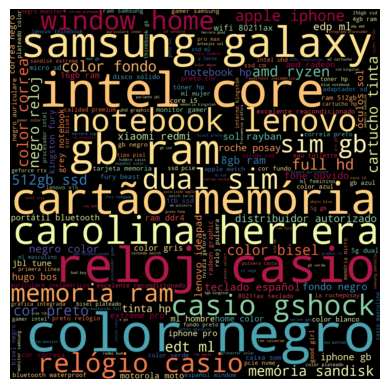

In [110]:
tokens_no_stop_pop = " ".join(df_domains_total["normalize"]).split(" ")
text_pop = df_domains_total["titles"]
wc = wordcloud.WordCloud(width=1500, height=1500, colormap="Spectral")
wc.generate(" ".join(tokens_no_stop_pop))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")

## _Fakes_

In [112]:
df_raw_text_fake = df_raw_text[df_raw_text["Fake"] == 1].copy()
df_domains_fake = (
    df_raw_text_fake.groupby(["Dominio_normalizado"])
    .agg(
        {
            "Titulo": lambda x: " ".join(x),
            "normalized": lambda x: " ".join(x),
            "seller_id": pd.Series.nunique,
            "site_id": pd.Series.nunique,
            "element_id": "count",
            "Marca": pd.Series.nunique,
            "Precio": [
                ("min", "min"),
                ("percentile25", lambda x: x.quantile(0.25)),
                ("mean", "mean"),
                ("median", "median"),
                ("percentile75", lambda x: x.quantile(0.75)),
                ("max", "max"),
            ],
            "number_of_words": [
                ("min", "min"),
                ("percentile25", lambda x: x.quantile(0.25)),
                ("mean", "mean"),
                ("median", "median"),
                ("percentile75", lambda x: x.quantile(0.75)),
                ("max", "max"),
            ],
        }
    )
    .reset_index()
)
df_domains_fake.columns = [
    "_".join(col).strip() for col in df_domains_fake.columns.values
]
df_domains_fake = df_domains_fake.rename(
    columns={
        "site_id_": "site_id",
        "Titulo_<lambda>": "titles",
        "normalized_<lambda>": "normalize",
        "seller_id_nunique": "num_sellers",
        "site_id_nunique": "num_countries",
        "element_id_count": "num_elements",
        "Marca_nunique": "num_marca",
        "Precio_mean": "mean_price",
        "Precio_percentile25": "percentile25_price",
        "Precio_percentile75": "percentile75_price",
        "Precio_median": "median_price",
        "Precio_min": "min_price",
        "Precio_max": "max_price",
        "number_of_words_mean": "mean_number_of_words",
        "number_of_words_min": "min_number_of_words",
        "number_of_words_max": "max_number_of_words",
        "number_of_words_percentile75": "percentile75_number_of_words",
        "number_of_words_percentile25": "percentile25_number_of_words",
        "number_of_words_median": "median_number_of_words",
    }
)
tk = nltk.TweetTokenizer()
df_domains_fake["tokens"] = df_domains_fake["titles"].apply(tk.tokenize)
df_domains_fake

,Dominio_normalizado_,titles,normalize,num_sellers,num_countries,num_elements,num_marca,min_price,percentile25_price,mean_price,median_price,percentile75_price,max_price,min_number_of_words,percentile25_number_of_words,mean_number_of_words,median_number_of_words,percentile75_number_of_words,max_number_of_words,tokens
0,AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS,Cabo Hdmi 4k 2.0 3m High-speed Hp Dhc-hd01 Bk ...,cabo hdmi 4k 20 3m highspeed hp dhchd01 bk cab...,3,3,3,1,17.45,19.9500,1.263300e+03,22.450,1886.225,3750.00,9,10.0,10.333333,11.0,11.0,11,"[Cabo, Hdmi, 4k, 2.0, 3m, High-speed, Hp, Dhc-..."
1,BODY_SKIN_CARE_PRODUCTS,Bálsamo Raparador Para Cuerpo La Roche-posay C...,bálsamo raparador cuerpo rocheposay cicaplast ...,21,5,23,3,22.95,208.3750,2.397645e+04,9580.000,37140.000,93145.00,4,8.0,9.608696,9.0,10.0,19,"[Bálsamo, Raparador, Para, Cuerpo, La, Roche-p..."
2,CELLPHONES,Calidad premium! Motorola Moto G04s Concord Bl...,calidad premium motorola moto g04s concord bla...,151,6,565,12,349.50,2144.5000,1.625981e+05,6388.350,154252.720,4799900.00,5,8.0,11.019469,10.0,13.0,30,"[Calidad, premium, !, Motorola, Moto, G04s, Co..."
3,COMPUTER_MICE,Xiaomi Wireless Mouse 3 Color Negro Xiaomi Mou...,xiaomi wireless mouse 3 color negro xiaomi mou...,25,6,37,6,19.50,144.5000,1.386984e+04,349.000,12292.500,99990.00,4,6.0,8.081081,7.0,10.0,14,"[Xiaomi, Wireless, Mouse, 3, Color, Negro, Xia..."
4,COMPUTER_MONITORS,Monitor Led Samsung Lf27t350 27'' Fullhd Ips 7...,monitor led samsung lf27t350 27 fullhd ip 75hz...,61,6,119,9,199.51,4849.2500,4.665739e+05,209990.000,495619.000,7861519.00,5,9.0,10.966387,11.0,13.0,18,"[Monitor, Led, Samsung, Lf27t350, 27, ', ', Fu..."
5,COMPUTER_PROCESSORS,Microprocesador Intel Core I5-14400 Bx80715144...,microprocesador intel core i514400 bx807151440...,44,5,103,4,203.21,1480.4200,1.711187e+05,54500.000,256749.500,1074959.50,5,9.0,10.543689,11.0,12.0,23,"[Microprocesador, Intel, Core, I5, -, 14400, B..."
6,DATA_CABLES_AND_ADAPTERS,Cable Samsung Tipo C A Tipo C 1mt Cable Samsun...,cable samsung tipo c tipo c 1mt cable samsung ...,20,6,24,4,11.17,47.1225,1.924408e+04,5994.750,25243.750,164116.00,7,9.0,10.833333,11.0,12.0,15,"[Cable, Samsung, Tipo, C, A, Tipo, C, 1mt, Cab..."
7,FACIAL_SKIN_CARE_PRODUCTS,Tratamiento Antiedad Para Ojos Hyalu B5 La Roc...,tratamiento antiedad ojos hyalu b5 roche posay...,49,6,103,2,23.60,228.8500,3.964476e+04,34990.000,69556.750,159400.00,4,8.0,10.475728,10.0,12.0,18,"[Tratamiento, Antiedad, Para, Ojos, Hyalu, B5,..."
8,GAMEPADS_AND_JOYSTICKS,Calidad premium! Sony Playstation 4 Mando Inal...,calidad premium sony playstation 4 mando inalá...,7,3,7,3,569.51,844.2500,6.528711e+04,999.500,76876.390,299999.50,6,7.5,9.428571,9.0,11.0,14,"[Calidad, premium, !, Sony, Playstation, 4, Ma..."
9,HARD_DRIVES_AND_SSDS,Disco Sólido Ssd Kingston A400 960gb Calidad p...,disco sólido ssd kingston a400 960gb calidad p...,65,6,157,8,105.95,484.5000,8.227808e+04,1708.000,62699.000,1715456.16,5,8.0,11.229299,10.0,13.0,24,"[Disco, Sólido, Ssd, Kingston, A400, 960gb, Ca..."


In [113]:
df_domains_fake["most_important_word"] = df_domains_fake["normalize"].apply(
    lambda text: most_important_no_stops(text)
)
df_domains_fake["10_most_important_words"] = df_domains_fake["normalize"].apply(
    lambda text: n_most_important_no_stops(text, 10)
)
df_domains_fake["10_more_important_bigrams"] = df_domains_fake["titles"].apply(
    lambda text: n_most_important_bigrams(text, 10)
)
df_domains_fake["lexical_richness"] = df_domains_fake["titles"].apply(
    lambda tokens: len(set(tokens)) / len(tokens)
)
df_domains_fake

,Dominio_normalizado_,titles,normalize,num_sellers,num_countries,num_elements,num_marca,min_price,percentile25_price,mean_price,...,percentile25_number_of_words,mean_number_of_words,median_number_of_words,percentile75_number_of_words,max_number_of_words,tokens,most_important_word,10_most_important_words,10_more_important_bigrams,lexical_richness
0,AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS,Cabo Hdmi 4k 2.0 3m High-speed Hp Dhc-hd01 Bk ...,cabo hdmi 4k 20 3m highspeed hp dhchd01 bk cab...,3,3,3,1,17.45,19.9500,1.263300e+03,...,10.0,10.333333,11.0,11.0,11,"[Cabo, Hdmi, 4k, 2.0, 3m, High-speed, Hp, Dhc-...",hdmi,"[hdmi, 4k, 20, hp, cable, cabo, 3m, highspeed,...","[(Cable, Hdmi), (Cabo, Hdmi), (Hdmi, 4k), (3m,...",0.237805
1,BODY_SKIN_CARE_PRODUCTS,Bálsamo Raparador Para Cuerpo La Roche-posay C...,bálsamo raparador cuerpo rocheposay cicaplast ...,21,5,23,3,22.95,208.3750,2.397645e+04,...,8.0,9.608696,9.0,10.0,19,"[Bálsamo, Raparador, Para, Cuerpo, La, Roche-p...",lipikar,"[lipikar, rocheposay, hidratante, baume, roche...","[(La, Roche-posay), (La, Roche), (Roche, Posay...",0.033599
2,CELLPHONES,Calidad premium! Motorola Moto G04s Concord Bl...,calidad premium motorola moto g04s concord bla...,151,6,565,12,349.50,2144.5000,1.625981e+05,...,8.0,11.019469,10.0,13.0,30,"[Calidad, premium, !, Motorola, Moto, G04s, Co...",gb,"[gb, ram, iphone, 128, galaxy, samsung, 5g, du...","[(Samsung, Galaxy), (Dual, Sim), (Apple, iPhon...",0.002100
3,COMPUTER_MICE,Xiaomi Wireless Mouse 3 Color Negro Xiaomi Mou...,xiaomi wireless mouse 3 color negro xiaomi mou...,25,6,37,6,19.50,144.5000,1.386984e+04,...,6.0,8.081081,7.0,10.0,14,"[Xiaomi, Wireless, Mouse, 3, Color, Negro, Xia...",mouse,"[mouse, lenovo, inalámbrico, hp, negro, 2, fio...","[(Mouse, Inalámbrico), (Color, Negro), (Sem, F...",0.032989
4,COMPUTER_MONITORS,Monitor Led Samsung Lf27t350 27'' Fullhd Ips 7...,monitor led samsung lf27t350 27 fullhd ip 75hz...,61,6,119,9,199.51,4849.2500,4.665739e+05,...,9.0,10.966387,11.0,13.0,18,"[Monitor, Led, Samsung, Lf27t350, 27, ', ', Fu...",monitor,"[monitor, samsung, gamer, color, negro, hd, fu...","[(Monitor, Gamer), (Gamer, Samsung), (Full, Hd...",0.008260
5,COMPUTER_PROCESSORS,Microprocesador Intel Core I5-14400 Bx80715144...,microprocesador intel core i514400 bx807151440...,44,5,103,4,203.21,1480.4200,1.711187e+05,...,9.0,10.543689,11.0,12.0,23,"[Microprocesador, Intel, Core, I5, -, 14400, B...",intel,"[intel, core, procesador, núcleos, frecuencia,...","[(Intel, Core), (De, Frecuencia), (Gamer, Inte...",0.007811
6,DATA_CABLES_AND_ADAPTERS,Cable Samsung Tipo C A Tipo C 1mt Cable Samsun...,cable samsung tipo c tipo c 1mt cable samsung ...,20,6,24,4,11.17,47.1225,1.924408e+04,...,9.0,10.833333,11.0,12.0,15,"[Cable, Samsung, Tipo, C, A, Tipo, C, 1mt, Cab...",usb,"[usb, cable, c, usbc, tipo, color, samsung, ca...","[(Color, Blanco), (Calidad, premium), (Cable, ...",0.039128
7,FACIAL_SKIN_CARE_PRODUCTS,Tratamiento Antiedad Para Ojos Hyalu B5 La Roc...,tratamiento antiedad ojos hyalu b5 roche posay...,49,6,103,2,23.60,228.8500,3.964476e+04,...,8.0,10.475728,10.0,12.0,18,"[Tratamiento, Antiedad, Para, Ojos, Hyalu, B5,...",roche,"[roche, posay, piel, tipo, rocheposay, effacla...","[(La, Roche), (Roche, Posay), (Tipo, De), (De,...",0.009238
8,GAMEPADS_AND_JOYSTICKS,Calidad premium! Sony Playstation 4 Mando Inal...,calidad premium sony playstation 4 mando inalá...,7,3,7,3,569.51,844.2500,6.528711e+04,...,7.5,9.428571,9.0,11.0,14,"[Calidad, premium, !, Sony, Playstation, 4, Ma...",nintendo,"[nintendo, switch, control, sony, 4, inalámbri...","[(Nintendo, Switch), (Pro, Controller), (Contr...",0.091837
9,HARD_DRIVES_AND_SSDS,Disco Sólido Ssd Kingston A400 960gb Calidad p...,disco sólido ssd kingston a400 960gb calidad p...,65,6,157,8,105.95,484.5000,8.227808e+04,...,8.0,11.229299,10.0,13.0,24,"[Disco, Sólido, Ssd, Kingston, A400, 960gb, Ca...",ssd,"[ssd, kingston, disco, sólido, interno, negro,...","[(Disco, Sólido), (Sólido, Ssd), (Interno, Kin...",0.006451


## _Not Fake_

In [114]:
df_raw_text_not_fake = df_raw_text[df_raw_text["Fake"] == 0].copy()
df_domains_not_fake = (
    df_raw_text_not_fake.groupby(["Dominio_normalizado"])
    .agg(
        {
            "Titulo": lambda x: " ".join(x),
            "normalized": lambda x: " ".join(x),
            "seller_id": pd.Series.nunique,
            "site_id": pd.Series.nunique,
            "element_id": "count",
            "Marca": pd.Series.nunique,
            "Precio": [
                ("min", "min"),
                ("percentile25", lambda x: x.quantile(0.25)),
                ("mean", "mean"),
                ("median", "median"),
                ("percentile75", lambda x: x.quantile(0.75)),
                ("max", "max"),
            ],
            "number_of_words": [
                ("min", "min"),
                ("percentile25", lambda x: x.quantile(0.25)),
                ("mean", "mean"),
                ("median", "median"),
                ("percentile75", lambda x: x.quantile(0.75)),
                ("max", "max"),
            ],
        }
    )
    .reset_index()
)
df_domains_not_fake.columns = [
    "_".join(col).strip() for col in df_domains_not_fake.columns.values
]
df_domains_not_fake = df_domains_not_fake.rename(
    columns={
        "site_id_": "site_id",
        "Titulo_<lambda>": "titles",
        "normalized_<lambda>": "normalize",
        "seller_id_nunique": "num_sellers",
        "site_id_nunique": "num_countries",
        "element_id_count": "num_elements",
        "Marca_nunique": "num_marca",
        "Precio_mean": "mean_price",
        "Precio_percentile25": "percentile25_price",
        "Precio_percentile75": "percentile75_price",
        "Precio_median": "median_price",
        "Precio_min": "min_price",
        "Precio_max": "max_price",
        "number_of_words_mean": "mean_number_of_words",
        "number_of_words_min": "min_number_of_words",
        "number_of_words_max": "max_number_of_words",
        "number_of_words_percentile75": "percentile75_number_of_words",
        "number_of_words_percentile25": "percentile25_number_of_words",
        "number_of_words_median": "median_number_of_words",
    }
)
tk = nltk.TweetTokenizer()
df_domains_not_fake["tokens"] = df_domains_not_fake["titles"].apply(tk.tokenize)
df_domains_not_fake

,Dominio_normalizado_,titles,normalize,num_sellers,num_countries,num_elements,num_marca,min_price,percentile25_price,mean_price,median_price,percentile75_price,max_price,min_number_of_words,percentile25_number_of_words,mean_number_of_words,median_number_of_words,percentile75_number_of_words,max_number_of_words,tokens
0,AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS,Cable Hdmi A Hdmi 2 Metros 2.0 4k 18gbps Pc No...,cable hdmi hdmi 2 metro 20 4k 18gbps pc notebo...,10,5,13,5,37.90,275.0800,1.314199e+04,8800.000,1.490331e+04,79900.00,4,8.0,9.461538,11.0,11.00,15,"[Cable, Hdmi, A, Hdmi, 2, Metros, 2.0, 4k, 18g..."
1,BODY_SKIN_CARE_PRODUCTS,La Roche Posay Lipikar Gel Lavant X 400 Ml La ...,roche posay lipikar gel lavant x 400 ml roche ...,52,6,161,1,48.90,536.0000,3.493479e+04,29545.000,5.275500e+04,137000.00,5,8.0,9.670807,9.0,11.00,21,"[La, Roche, Posay, Lipikar, Gel, Lavant, X, 40..."
2,CELLPHONES,Samsung Galaxy A15 128 Gb Azul Claro 4 Gb Ram ...,samsung galaxy a15 128 gb azul claro 4 gb ram ...,229,6,4657,5,319.00,3103.8000,2.847662e+05,9543.850,2.999990e+05,11290350.00,4,8.0,10.541980,10.0,12.00,29,"[Samsung, Galaxy, A15, 128, Gb, Azul, Claro, 4..."
3,COMPUTER_MICE,Mouse Lenovo 530 Inalambrico 1200dpi 3 Botones...,mouse lenovo 530 inalambrico 1200dpi 3 botones...,83,6,253,5,35.10,150.6300,3.047313e+04,7990.000,4.289000e+04,475247.00,3,6.0,7.466403,7.0,9.00,13,"[Mouse, Lenovo, 530, Inalambrico, 1200dpi, 3, ..."
4,COMPUTER_MONITORS,Monitor Gamer Samsung Con Pantalla De 25 60hz...,monitor gamer samsung pantalla 25 60hz 220v re...,152,6,995,5,329.80,3464.3000,5.176714e+05,265000.000,6.121455e+05,9999900.00,3,9.0,10.106533,10.0,11.00,23,"[Monitor, Gamer, Samsung, Con, Pantalla, De, 2..."
5,COMPUTER_PROCESSORS,Microprocesador Intel Core I3 12100 12mb Bx807...,microprocesador intel core i3 12100 12mb bx807...,94,5,863,2,29.90,2004.4300,1.908790e+05,7518.810,2.209514e+05,4069788.36,4,9.0,10.378911,10.0,12.00,23,"[Microprocesador, Intel, Core, I3, 12100, 12mb..."
6,DATA_CABLES_AND_ADAPTERS,Apple Cable Lightning A Usb-c De 1 Metro - Dis...,apple cable lightning usbc 1 metro distribuido...,84,6,233,7,12.90,69.9900,2.727174e+04,2864.000,3.000000e+04,253199.00,3,8.0,9.557940,9.0,11.00,21,"[Apple, Cable, Lightning, A, Usb-c, De, 1, Met..."
7,FACIAL_SKIN_CARE_PRODUCTS,La Roche-posay Crema Mela B3 Fps30+ 40ml Momen...,rocheposay crema mela b3 fps30 40ml momento ap...,72,6,783,2,33.38,364.9300,4.642909e+04,32980.000,8.428600e+04,269456.00,4,7.0,9.719029,9.0,12.00,24,"[La, Roche-posay, Crema, Mela, B3, Fps, 30, +,..."
8,GAMEPADS_AND_JOYSTICKS,Controlador Inalámbrico Sony Dualsense Edge Ps...,controlador inalámbrico sony dualsense edge ps...,40,5,95,3,119.00,469.0000,5.555108e+04,699.000,3.861425e+03,586059.00,4,7.0,7.631579,7.0,8.00,15,"[Controlador, Inalámbrico, Sony, Dualsense, Ed..."
9,HARD_DRIVES_AND_SSDS,Ssd Externo Kingston Xs1000 1tb Negro Usb 3.2 ...,ssd externo kingston xs1000 1tb negro usb 32 g...,156,6,1268,7,119.90,891.6450,1.608483e+05,3264.000,1.659900e+05,7073609.00,3,8.0,10.543375,10.0,12.00,24,"[Ssd, Externo, Kingston, Xs1000, 1tb, Negro, U..."


In [115]:
df_domains_not_fake["most_important_word"] = df_domains_not_fake["normalize"].apply(
    lambda text: most_important_no_stops(text)
)
df_domains_not_fake["10_most_important_words"] = df_domains_not_fake["normalize"].apply(
    lambda text: n_most_important_no_stops(text, 10)
)
df_domains_not_fake["10_more_important_bigrams"] = df_domains_not_fake["titles"].apply(
    lambda text: n_most_important_bigrams(text, 10)
)
df_domains_not_fake["lexical_richness"] = df_domains_not_fake["titles"].apply(
    lambda tokens: len(set(tokens)) / len(tokens)
)
df_domains_not_fake

,Dominio_normalizado_,titles,normalize,num_sellers,num_countries,num_elements,num_marca,min_price,percentile25_price,mean_price,...,percentile25_number_of_words,mean_number_of_words,median_number_of_words,percentile75_number_of_words,max_number_of_words,tokens,most_important_word,10_most_important_words,10_more_important_bigrams,lexical_richness
0,AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS,Cable Hdmi A Hdmi 2 Metros 2.0 4k 18gbps Pc No...,cable hdmi hdmi 2 metro 20 4k 18gbps pc notebo...,10,5,13,5,37.90,275.0800,1.314199e+04,...,8.0,9.461538,11.0,11.00,15,"[Cable, Hdmi, A, Hdmi, 2, Metros, 2.0, 4k, 18g...",hdmi,"[hdmi, cable, 2, hp, metro, 1, cabo, dhchd01v,...","[(Cable, Hdmi), (Metros, 2.0), (Pc, Notebook),...",0.075835
1,BODY_SKIN_CARE_PRODUCTS,La Roche Posay Lipikar Gel Lavant X 400 Ml La ...,roche posay lipikar gel lavant x 400 ml roche ...,52,6,161,1,48.90,536.0000,3.493479e+04,...,8.0,9.670807,9.0,11.00,21,"[La, Roche, Posay, Lipikar, Gel, Lavant, X, 40...",lipikar,"[lipikar, rocheposay, baume, roche, posay, hid...","[(La, Roche-posay), (La, Roche), (Roche, Posay...",0.005847
2,CELLPHONES,Samsung Galaxy A15 128 Gb Azul Claro 4 Gb Ram ...,samsung galaxy a15 128 gb azul claro 4 gb ram ...,229,6,4657,5,319.00,3103.8000,2.847662e+05,...,8.0,10.541980,10.0,12.00,29,"[Samsung, Galaxy, A15, 128, Gb, Azul, Claro, 4...",gb,"[gb, ram, galaxy, samsung, 128, iphone, 5g, du...","[(Samsung, Galaxy), (Dual, Sim), (Apple, iPhon...",0.000303
3,COMPUTER_MICE,Mouse Lenovo 530 Inalambrico 1200dpi 3 Botones...,mouse lenovo 530 inalambrico 1200dpi 3 botones...,83,6,253,5,35.10,150.6300,3.047313e+04,...,6.0,7.466403,7.0,9.00,13,"[Mouse, Lenovo, 530, Inalambrico, 1200dpi, 3, ...",mouse,"[mouse, hp, negro, color, inalámbrico, usb, le...","[(Negro, Mouse), (Mouse, Inalámbrico), (Mouse,...",0.006087
4,COMPUTER_MONITORS,Monitor Gamer Samsung Con Pantalla De 25 60hz...,monitor gamer samsung pantalla 25 60hz 220v re...,152,6,995,5,329.80,3464.3000,5.176714e+05,...,9.0,10.106533,10.0,11.00,23,"[Monitor, Gamer, Samsung, Con, Pantalla, De, 2...",monitor,"[monitor, samsung, gamer, hd, negro, full, col...","[(Monitor, Gamer), (Full, Hd), (Con, Pantalla)...",0.001218
5,COMPUTER_PROCESSORS,Microprocesador Intel Core I3 12100 12mb Bx807...,microprocesador intel core i3 12100 12mb bx807...,94,5,863,2,29.90,2004.4300,1.908790e+05,...,9.0,10.378911,10.0,12.00,23,"[Microprocesador, Intel, Core, I3, 12100, 12mb...",intel,"[intel, core, núcleos, procesador, frecuencia,...","[(Intel, Core), (De, Frecuencia), (Gráfica, In...",0.001082
6,DATA_CABLES_AND_ADAPTERS,Apple Cable Lightning A Usb-c De 1 Metro - Dis...,apple cable lightning usbc 1 metro distribuido...,84,6,233,7,12.90,69.9900,2.727174e+04,...,8.0,9.557940,9.0,11.00,21,"[Apple, Cable, Lightning, A, Usb-c, De, 1, Met...",usb,"[usb, cable, c, tipo, usbc, cabo, lightning, b...","[(Usb, Tipo), (Distribuidor, Autorizado), (Cab...",0.005351
7,FACIAL_SKIN_CARE_PRODUCTS,La Roche-posay Crema Mela B3 Fps30+ 40ml Momen...,rocheposay crema mela b3 fps30 40ml momento ap...,72,6,783,2,33.38,364.9300,4.642909e+04,...,7.0,9.719029,9.0,12.00,24,"[La, Roche-posay, Crema, Mela, B3, Fps, 30, +,...",roche,"[roche, posay, tipo, piel, rocheposay, effacla...","[(La, Roche), (Roche, Posay), (Tipo, De), (La,...",0.001468
8,GAMEPADS_AND_JOYSTICKS,Controlador Inalámbrico Sony Dualsense Edge Ps...,controlador inalámbrico sony dualsense edge ps...,40,5,95,3,119.00,469.0000,5.555108e+04,...,7.0,7.631579,7.0,8.00,15,"[Controlador, Inalámbrico, Sony, Dualsense, Ed...",dualsense,"[dualsense, playstation, inalámbrico, ps5, con...","[(Sem, Fio), (Inalámbrico, Dualsense), (Dualse...",0.012328
9,HARD_DRIVES_AND_SSDS,Ssd Externo Kingston Xs1000 1tb Negro Usb 3.2 ...,ssd externo kingston xs1000 1tb negro usb 32 g...,156,6,1268,7,119.90,891.6450,1.608483e+05,...,8.0,10.543375,10.0,12.00,24,"[Ssd, Externo, Kingston, Xs1000, 1tb, Negro, U...",ssd,"[ssd, kingston, disco, sólido, interno, negro,...","[(Disco, Sólido), (Sólido, Ssd), (Interno, Kin...",0.000869

# **Domain and Site Analysis**

## _All_

In [116]:
df_domains_site_total = (
    df_raw_text.groupby(["site_id", "Dominio_normalizado"])
    .agg(
        {
            "Titulo": lambda x: " ".join(x),
            "normalized": lambda x: " ".join(x),
            "seller_id": pd.Series.nunique,
            "element_id": "count",
            "Marca": pd.Series.nunique,
            "Precio": [
                ("min", "min"),
                ("percentile25", lambda x: x.quantile(0.25)),
                ("mean", "mean"),
                ("median", "median"),
                ("percentile75", lambda x: x.quantile(0.75)),
                ("max", "max"),
            ],
            "number_of_words": [
                ("min", "min"),
                ("percentile25", lambda x: x.quantile(0.25)),
                ("mean", "mean"),
                ("median", "median"),
                ("percentile75", lambda x: x.quantile(0.75)),
                ("max", "max"),
            ],
        }
    )
    .reset_index()
)
df_domains_site_total.columns = [
    "_".join(col).strip() for col in df_domains_site_total.columns.values
]
df_domains_site_total = df_domains_site_total.rename(
    columns={
        "site_id_": "site_id",
        "Titulo_<lambda>": "titles",
        "normalized_<lambda>": "normalize",
        "seller_id_nunique": "num_sellers",
        "site_id_nunique": "num_countries",
        "element_id_count": "num_elements",
        "Marca_nunique": "num_marca",
        "Precio_mean": "mean_price",
        "Precio_percentile25": "percentile25_price",
        "Precio_percentile75": "percentile75_price",
        "Precio_median": "median_price",
        "Precio_min": "min_price",
        "Precio_max": "max_price",
        "number_of_words_mean": "mean_number_of_words",
        "number_of_words_min": "min_number_of_words",
        "number_of_words_max": "max_number_of_words",
        "number_of_words_percentile75": "percentile75_number_of_words",
        "number_of_words_percentile25": "percentile25_number_of_words",
        "number_of_words_median": "median_number_of_words",
    }
)
tk = nltk.TweetTokenizer()
df_domains_site_total["tokens"] = df_domains_site_total["titles"].apply(tk.tokenize)
df_domains_site_total

,site_id,Dominio_normalizado_,titles,normalize,num_sellers,num_elements,num_marca,min_price,percentile25_price,mean_price,median_price,percentile75_price,max_price,min_number_of_words,percentile25_number_of_words,mean_number_of_words,median_number_of_words,percentile75_number_of_words,max_number_of_words,tokens
0,ARGENTINA,AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS,Cable Hdmi A Hdmi 2 Metros 2.0 4k 18gbps Pc No...,cable hdmi hdmi 2 metro 20 4k 18gbps pc notebo...,1,1,1,12999.00,12999.000,12999.000000,12999.000,12999.00,12999.00,11,11.0,11.000000,11.0,11.0,11,"[Cable, Hdmi, A, Hdmi, 2, Metros, 2.0, 4k, 18g..."
1,ARGENTINA,BODY_SKIN_CARE_PRODUCTS,La Roche Posay Lipikar Gel Lavant X 400 Ml La ...,roche posay lipikar gel lavant x 400 ml roche ...,18,90,2,14772.50,34490.025,56071.618556,50525.005,78455.75,112705.00,6,8.0,10.100000,9.0,10.0,19,"[La, Roche, Posay, Lipikar, Gel, Lavant, X, 40..."
2,ARGENTINA,CELLPHONES,Samsung Galaxy A15 128 Gb Azul Claro 4 Gb Ram ...,samsung galaxy a15 128 gb azul claro 4 gb ram ...,75,1234,9,64500.00,289286.500,636439.978622,413556.000,676483.50,5999999.00,5,7.0,9.097245,9.0,11.0,16,"[Samsung, Galaxy, A15, 128, Gb, Azul, Claro, 4..."
3,ARGENTINA,COMPUTER_MICE,Mouse Lenovo 530 Inalambrico 1200dpi 3 Botones...,mouse lenovo 530 inalambrico 1200dpi 3 botones...,24,91,4,6999.00,23217.000,57509.409780,44153.000,70449.50,352159.00,5,7.0,8.219780,8.0,10.0,12,"[Mouse, Lenovo, 530, Inalambrico, 1200dpi, 3, ..."
4,ARGENTINA,COMPUTER_MONITORS,Monitor Gamer Samsung Con Pantalla De 25 60hz...,monitor gamer samsung pantalla 25 60hz 220v re...,42,543,7,89999.50,277996.085,717654.600626,450000.000,770799.00,9663619.00,4,9.0,10.254144,10.0,11.0,15,"[Monitor, Gamer, Samsung, Con, Pantalla, De, 2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,PERU,SPEAKERS,Parlante Portable Jbl Go3 Bluetooth Sumergible...,parlante portable jbl go3 bluetooth sumergible...,21,159,10,29.70,284.500,1031.636730,599.000,1474.50,6174.05,4,8.0,9.012579,9.0,10.0,15,"[Parlante, Portable, Jbl, Go3, Bluetooth, Sume..."
153,PERU,SUNGLASSES,Versace Gafas De Sol Ve4361 Unisex,versace gafas sol ve4361 unisex,1,1,1,906.15,906.150,906.150000,906.150,906.15,906.15,5,5.0,5.000000,5.0,5.0,5,"[Versace, Gafas, De, Sol, Ve4361, Unisex]"
154,PERU,SUNSCREENS,Protector Solar Infantil La Roche-posay Anthel...,protector solar infantil rocheposay anthelios ...,3,17,1,82.95,119.900,150.585294,139.900,144.90,299.80,7,8.0,8.529412,9.0,9.0,10,"[Protector, Solar, Infantil, La, Roche-posay, ..."
155,PERU,TONERS,Tóner Hp 130a Color Cian Toner Hp Laserjet 85a...,tóner hp 130a color cian toner hp laserjet 85a...,3,5,1,328.90,328.900,499.140000,329.900,709.00,799.00,5,6.0,6.000000,6.0,6.0,7,"[Tóner, Hp, 130a, Color, Cian, Toner, Hp, Lase..."


In [118]:
df_domains_site_total["most_important_word"] = df_domains_site_total["normalize"].apply(
    lambda text: most_important_no_stops(text)
)
df_domains_site_total["10_most_important_words"] = df_domains_site_total["normalize"].apply(
    lambda text: n_most_important_no_stops(text, 10)
)
df_domains_site_total["10_more_important_bigrams"] = df_domains_site_total["titles"].apply(
    lambda text: n_most_important_bigrams(text, 10)
)
df_domains_site_total["lexical_richness"] = df_domains_site_total["titles"].apply(
    lambda tokens: len(set(tokens)) / len(tokens)
)
df_domains_site_total

,site_id,Dominio_normalizado_,titles,normalize,num_sellers,num_elements,num_marca,min_price,percentile25_price,mean_price,...,percentile25_number_of_words,mean_number_of_words,median_number_of_words,percentile75_number_of_words,max_number_of_words,tokens,most_important_word,10_most_important_words,10_more_important_bigrams,lexical_richness
0,ARGENTINA,AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS,Cable Hdmi A Hdmi 2 Metros 2.0 4k 18gbps Pc No...,cable hdmi hdmi 2 metro 20 4k 18gbps pc notebo...,1,1,1,12999.00,12999.000,12999.000000,...,11.0,11.000000,11.0,11.0,11,"[Cable, Hdmi, A, Hdmi, 2, Metros, 2.0, 4k, 18g...",hdmi,"[hdmi, cable, 2, metro, 20, 4k, 18gbps, pc, no...","[(Cable, Hdmi), (Metros, 2.0), (4k, 18gbps), (...",0.500000
1,ARGENTINA,BODY_SKIN_CARE_PRODUCTS,La Roche Posay Lipikar Gel Lavant X 400 Ml La ...,roche posay lipikar gel lavant x 400 ml roche ...,18,90,2,14772.50,34490.025,56071.618556,...,8.0,10.100000,9.0,10.0,19,"[La, Roche, Posay, Lipikar, Gel, Lavant, X, 40...",lipikar,"[lipikar, roche, posay, rocheposay, cicaplast,...","[(La, Roche), (Roche, Posay), (La, Roche-posay...",0.007608
2,ARGENTINA,CELLPHONES,Samsung Galaxy A15 128 Gb Azul Claro 4 Gb Ram ...,samsung galaxy a15 128 gb azul claro 4 gb ram ...,75,1234,9,64500.00,289286.500,636439.978622,...,7.0,9.097245,9.0,11.0,16,"[Samsung, Galaxy, A15, 128, Gb, Azul, Claro, 4...",gb,"[gb, ram, moto, motorola, samsung, galaxy, 128...","[(Samsung, Galaxy), (Motorola, Moto), (Dual, S...",0.001297
3,ARGENTINA,COMPUTER_MICE,Mouse Lenovo 530 Inalambrico 1200dpi 3 Botones...,mouse lenovo 530 inalambrico 1200dpi 3 botones...,24,91,4,6999.00,23217.000,57509.409780,...,7.0,8.219780,8.0,10.0,12,"[Mouse, Lenovo, 530, Inalambrico, 1200dpi, 3, ...",mouse,"[mouse, color, inalámbrico, negro, xiaomi, wir...","[(Mouse, Inalámbrico), (Inalámbrico, Xiaomi), ...",0.012738
4,ARGENTINA,COMPUTER_MONITORS,Monitor Gamer Samsung Con Pantalla De 25 60hz...,monitor gamer samsung pantalla 25 60hz 220v re...,42,543,7,89999.50,277996.085,717654.600626,...,9.0,10.254144,10.0,11.0,15,"[Monitor, Gamer, Samsung, Con, Pantalla, De, 2...",monitor,"[monitor, samsung, gamer, hd, 220v, full, negr...","[(Monitor, Gamer), (Full, Hd), (Con, Pantalla)...",0.001827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,PERU,SPEAKERS,Parlante Portable Jbl Go3 Bluetooth Sumergible...,parlante portable jbl go3 bluetooth sumergible...,21,159,10,29.70,284.500,1031.636730,...,8.0,9.012579,9.0,10.0,15,"[Parlante, Portable, Jbl, Go3, Bluetooth, Sume...",bluetooth,"[bluetooth, jbl, portátil, bocina, 220v, water...","[(Con, Bluetooth), (Portátil, Con), (Bocina, J...",0.006686
153,PERU,SUNGLASSES,Versace Gafas De Sol Ve4361 Unisex,versace gafas sol ve4361 unisex,1,1,1,906.15,906.150,906.150000,...,5.0,5.000000,5.0,5.0,5,"[Versace, Gafas, De, Sol, Ve4361, Unisex]",versace,"[versace, gafas, sol, ve4361, unisex]","[(Versace, Gafas), (Gafas, De), (Sol, Ve4361),...",0.617647
154,PERU,SUNSCREENS,Protector Solar Infantil La Roche-posay Anthel...,protector solar infantil rocheposay anthelios ...,3,17,1,82.95,119.900,150.585294,...,8.0,8.529412,9.0,9.0,10,"[Protector, Solar, Infantil, La, Roche-posay, ...",anthelios,"[anthelios, protector, solar, roche, posay, ro...","[(Protector, Solar), (La, Roche), (La, Roche-p...",0.042727
155,PERU,TONERS,Tóner Hp 130a Color Cian Toner Hp Laserjet 85a...,tóner hp 130a color cian toner hp laserjet 85a...,3,5,1,328.90,328.900,499.140000,...,6.0,6.000000,6.0,6.0,7,"[Tóner, Hp, 130a, Color, Cian, Toner, Hp, Lase...",hp,"[hp, color, tóner, laserjet, negro, 130a, tone...","[(Tóner, Hp), (Hp, Laserjet), (Color, Negro), ...",0.182857


## _Fake_

In [119]:
df_raw_text_fake = df_raw_text[df_raw_text["Fake"] == 1].copy()
df_domains_site_fake = (
    df_raw_text_fake.groupby(["site_id", "Dominio_normalizado"])
    .agg(
        {
            "Titulo": lambda x: " ".join(x),
            "normalized": lambda x: " ".join(x),
            "seller_id": pd.Series.nunique,
            "element_id": "count",
            "Marca": pd.Series.nunique,
            "Precio": [
                ("min", "min"),
                ("percentile25", lambda x: x.quantile(0.25)),
                ("mean", "mean"),
                ("median", "median"),
                ("percentile75", lambda x: x.quantile(0.75)),
                ("max", "max"),
            ],
            "number_of_words": [
                ("min", "min"),
                ("percentile25", lambda x: x.quantile(0.25)),
                ("mean", "mean"),
                ("median", "median"),
                ("percentile75", lambda x: x.quantile(0.75)),
                ("max", "max"),
            ],
        }
    )
    .reset_index()
)
df_domains_site_fake.columns = [
    "_".join(col).strip() for col in df_domains_site_fake.columns.values
]
df_domains_site_fake = df_domains_site_fake.rename(
    columns={
        "site_id_": "site_id",
        "Titulo_<lambda>": "titles",
        "normalized_<lambda>": "normalize",
        "seller_id_nunique": "num_sellers",
        "site_id_nunique": "num_countries",
        "element_id_count": "num_elements",
        "Marca_nunique": "num_marca",
        "Precio_mean": "mean_price",
        "Precio_percentile25": "percentile25_price",
        "Precio_percentile75": "percentile75_price",
        "Precio_median": "median_price",
        "Precio_min": "min_price",
        "Precio_max": "max_price",
        "number_of_words_mean": "mean_number_of_words",
        "number_of_words_min": "min_number_of_words",
        "number_of_words_max": "max_number_of_words",
        "number_of_words_percentile75": "percentile75_number_of_words",
        "number_of_words_percentile25": "percentile25_number_of_words",
        "number_of_words_median": "median_number_of_words",
    }
)
tk = nltk.TweetTokenizer()
df_domains_site_fake["tokens"] = df_domains_site_fake["titles"].apply(tk.tokenize)
df_domains_site_fake

,site_id,Dominio_normalizado_,titles,normalize,num_sellers,num_elements,num_marca,min_price,percentile25_price,mean_price,median_price,percentile75_price,max_price,min_number_of_words,percentile25_number_of_words,mean_number_of_words,median_number_of_words,percentile75_number_of_words,max_number_of_words,tokens
0,ARGENTINA,BODY_SKIN_CARE_PRODUCTS,Bálsamo Raparador Para Cuerpo La Roche-posay C...,bálsamo raparador cuerpo rocheposay cicaplast ...,10,10,2,14772.50,27273.3425,51635.128000,50766.50,77512.4925,93145.00,7,8.25,10.800000,9.0,10.75,19,"[Bálsamo, Raparador, Para, Cuerpo, La, Roche-p..."
1,ARGENTINA,CELLPHONES,Calidad premium! Motorola Moto G04s Concord Bl...,calidad premium motorola moto g04s concord bla...,46,127,8,64500.00,187386.2500,456108.268031,344499.00,592999.0000,2399999.00,5,8.00,9.661417,10.0,11.00,15,"[Calidad, premium, !, Motorola, Moto, G04s, Co..."
2,ARGENTINA,COMPUTER_MICE,Xiaomi Wireless Mouse 3 Color Negro Xiaomi Mou...,xiaomi wireless mouse 3 color negro xiaomi mou...,8,9,3,6999.00,11341.5000,28071.158889,12292.50,33657.0000,96599.00,6,6.00,8.888889,10.0,11.00,12,"[Xiaomi, Wireless, Mouse, 3, Color, Negro, Xia..."
3,ARGENTINA,COMPUTER_MONITORS,Monitor Led Samsung Lf27t350 27'' Fullhd Ips 7...,monitor led samsung lf27t350 27 fullhd ip 75hz...,19,64,5,89999.50,215749.1250,707480.830625,333769.50,708324.6250,7861519.00,5,9.75,10.843750,11.0,12.00,15,"[Monitor, Led, Samsung, Lf27t350, 27, ', ', Fu..."
4,ARGENTINA,COMPUTER_PROCESSORS,Microprocesador Intel Core I5-14400 Bx80715144...,microprocesador intel core i514400 bx807151440...,18,52,4,37999.50,97037.0000,331343.173462,235494.75,525024.0000,1074959.50,5,10.00,10.980769,11.0,12.00,23,"[Microprocesador, Intel, Core, I5, -, 14400, B..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,PERU,RAM_MEMORY_MODULES,Memoria Ram Fury Beast Ddr4 Gamer Color Negro ...,memoria ram fury beast ddr4 gamer color negro ...,4,8,2,30.15,80.6725,153.203750,147.45,217.0625,275.00,8,8.75,10.000000,10.0,11.25,12,"[Memoria, Ram, Fury, Beast, Ddr, 4, Gamer, Col..."
135,PERU,SMARTWATCHES,"Reloj Smartwatch Xiaomi Redmi Watch 5 Lite 1,9...",reloj smartwatch xiaomi redmi watch 5 lite 196...,3,4,3,214.95,224.0925,471.997500,248.52,496.4250,1176.00,7,10.75,12.000000,12.5,13.75,16,"[Reloj, Smartwatch, Xiaomi, Redmi, Watch, 5, L..."
136,PERU,SPEAKERS,Altavoz De Audio Bidireccional De Automóvil St...,altavoz audio bidireccional automóvil stage342...,9,23,6,29.70,249.5400,734.044783,449.00,652.7500,4199.00,5,7.00,9.130435,10.0,10.00,13,"[Altavoz, De, Audio, Bidireccional, De, Automó..."
137,PERU,SUNSCREENS,Protector Solar Infantil La Roche-posay Anthel...,protector solar infantil rocheposay anthelios ...,1,1,1,82.95,82.9500,82.950000,82.95,82.9500,82.95,9,9.00,9.000000,9.0,9.00,9,"[Protector, Solar, Infantil, La, Roche-posay, ..."


In [120]:
df_domains_site_fake["most_important_word"] = df_domains_site_fake["normalize"].apply(
    lambda text: most_important_no_stops(text)
)
df_domains_site_fake["10_most_important_words"] = df_domains_site_fake["normalize"].apply(
    lambda text: n_most_important_no_stops(text, 10)
)
df_domains_site_fake["10_more_important_bigrams"] = df_domains_site_fake["titles"].apply(
    lambda text: n_most_important_bigrams(text, 10)
)
df_domains_site_fake["lexical_richness"] = df_domains_site_fake["titles"].apply(
    lambda tokens: len(set(tokens)) / len(tokens)
)
df_domains_site_fake

,site_id,Dominio_normalizado_,titles,normalize,num_sellers,num_elements,num_marca,min_price,percentile25_price,mean_price,...,percentile25_number_of_words,mean_number_of_words,median_number_of_words,percentile75_number_of_words,max_number_of_words,tokens,most_important_word,10_most_important_words,10_more_important_bigrams,lexical_richness
0,ARGENTINA,BODY_SKIN_CARE_PRODUCTS,Bálsamo Raparador Para Cuerpo La Roche-posay C...,bálsamo raparador cuerpo rocheposay cicaplast ...,10,10,2,14772.50,27273.3425,51635.128000,...,8.25,10.800000,9.0,10.75,19,"[Bálsamo, Raparador, Para, Cuerpo, La, Roche-p...",lipikar,"[lipikar, rocheposay, baume, roche, posay, bál...","[(La, Roche-posay), (La, Roche), (Roche, Posay...",0.061684
1,ARGENTINA,CELLPHONES,Calidad premium! Motorola Moto G04s Concord Bl...,calidad premium motorola moto g04s concord bla...,46,127,8,64500.00,187386.2500,456108.268031,...,8.00,9.661417,10.0,11.00,15,"[Calidad, premium, !, Motorola, Moto, G04s, Co...",gb,"[gb, ram, moto, motorola, samsung, 128, galaxy...","[(Samsung, Galaxy), (Dual, Sim), (Motorola, Mo...",0.010250
2,ARGENTINA,COMPUTER_MICE,Xiaomi Wireless Mouse 3 Color Negro Xiaomi Mou...,xiaomi wireless mouse 3 color negro xiaomi mou...,8,9,3,6999.00,11341.5000,28071.158889,...,6.00,8.888889,10.0,11.00,12,"[Xiaomi, Wireless, Mouse, 3, Color, Negro, Xia...",mouse,"[mouse, xiaomi, color, negro, wireless, 3, ina...","[(Color, Negro), (Xiaomi, Wireless), (Wireless...",0.101695
3,ARGENTINA,COMPUTER_MONITORS,Monitor Led Samsung Lf27t350 27'' Fullhd Ips 7...,monitor led samsung lf27t350 27 fullhd ip 75hz...,19,64,5,89999.50,215749.1250,707480.830625,...,9.75,10.843750,11.0,12.00,15,"[Monitor, Led, Samsung, Lf27t350, 27, ', ', Fu...",monitor,"[monitor, samsung, gamer, 220v, negro, color, ...","[(Monitor, Gamer), (Gamer, Samsung), (Color, N...",0.012973
4,ARGENTINA,COMPUTER_PROCESSORS,Microprocesador Intel Core I5-14400 Bx80715144...,microprocesador intel core i514400 bx807151440...,18,52,4,37999.50,97037.0000,331343.173462,...,10.00,10.980769,11.0,12.00,23,"[Microprocesador, Intel, Core, I5, -, 14400, B...",intel,"[intel, core, procesador, núcleos, frecuencia,...","[(Intel, Core), (De, Frecuencia), (Procesador,...",0.013645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,PERU,RAM_MEMORY_MODULES,Memoria Ram Fury Beast Ddr4 Gamer Color Negro ...,memoria ram fury beast ddr4 gamer color negro ...,4,8,2,30.15,80.6725,153.203750,...,8.75,10.000000,10.0,11.25,12,"[Memoria, Ram, Fury, Beast, Ddr, 4, Gamer, Col...",memoria,"[memoria, kingston, ram, fury, beast, 1, 8gb, ...","[(Memoria, Ram), (Fury, Beast), (Kingston, Fur...",0.093985
135,PERU,SMARTWATCHES,"Reloj Smartwatch Xiaomi Redmi Watch 5 Lite 1,9...",reloj smartwatch xiaomi redmi watch 5 lite 196...,3,4,3,214.95,224.0925,471.997500,...,10.75,12.000000,12.5,13.75,16,"[Reloj, Smartwatch, Xiaomi, Redmi, Watch, 5, L...",watch,"[watch, smartwatch, xiaomi, redmi, gps, black,...","[(Redmi, Watch), (Reloj, Smartwatch), (Smartwa...",0.163987
136,PERU,SPEAKERS,Altavoz De Audio Bidireccional De Automóvil St...,altavoz audio bidireccional automóvil stage342...,9,23,6,29.70,249.5400,734.044783,...,7.00,9.130435,10.0,10.00,13,"[Altavoz, De, Audio, Bidireccional, De, Automó...",jbl,"[jbl, bluetooth, portátil, bocina, waterproof,...","[(Bocina, Jbl), (Con, Bluetooth), (Portátil, C...",0.040252
137,PERU,SUNSCREENS,Protector Solar Infantil La Roche-posay Anthel...,protector solar infantil rocheposay anthelios ...,1,1,1,82.95,82.9500,82.950000,...,9.00,9.000000,9.0,9.00,9,"[Protector, Solar, Infantil, La, Roche-posay, ...",protector,"[protector, solar, infantil, rocheposay, anthe...","[(Protector, Solar), (Solar, Infantil), (Infan...",0.337209


## _Not Fake_

In [121]:
df_raw_text_not_fake = df_raw_text[df_raw_text["Fake"] == 0].copy()
df_domains_site_not_fake = (
    df_raw_text_not_fake.groupby(["site_id", "Dominio_normalizado"])
    .agg(
        {
            "Titulo": lambda x: " ".join(x),
            "normalized": lambda x: " ".join(x),
            "seller_id": pd.Series.nunique,
            "element_id": "count",
            "Marca": pd.Series.nunique,
            "Precio": [
                ("min", "min"),
                ("percentile25", lambda x: x.quantile(0.25)),
                ("mean", "mean"),
                ("median", "median"),
                ("percentile75", lambda x: x.quantile(0.75)),
                ("max", "max"),
            ],
            "number_of_words": [
                ("min", "min"),
                ("percentile25", lambda x: x.quantile(0.25)),
                ("mean", "mean"),
                ("median", "median"),
                ("percentile75", lambda x: x.quantile(0.75)),
                ("max", "max"),
            ],
        }
    )
    .reset_index()
)
df_domains_site_not_fake.columns = [
    "_".join(col).strip() for col in df_domains_site_not_fake.columns.values
]
df_domains_site_not_fake = df_domains_site_not_fake.rename(
    columns={
        "site_id_": "site_id",
        "Titulo_<lambda>": "titles",
        "normalized_<lambda>": "normalize",
        "seller_id_nunique": "num_sellers",
        "site_id_nunique": "num_countries",
        "element_id_count": "num_elements",
        "Marca_nunique": "num_marca",
        "Precio_mean": "mean_price",
        "Precio_percentile25": "percentile25_price",
        "Precio_percentile75": "percentile75_price",
        "Precio_median": "median_price",
        "Precio_min": "min_price",
        "Precio_max": "max_price",
        "number_of_words_mean": "mean_number_of_words",
        "number_of_words_min": "min_number_of_words",
        "number_of_words_max": "max_number_of_words",
        "number_of_words_percentile75": "percentile75_number_of_words",
        "number_of_words_percentile25": "percentile25_number_of_words",
        "number_of_words_median": "median_number_of_words",
    }
)
tk = nltk.TweetTokenizer()
df_domains_site_not_fake["tokens"] = df_domains_site_not_fake["titles"].apply(tk.tokenize)
df_domains_site_not_fake

,site_id,Dominio_normalizado_,titles,normalize,num_sellers,num_elements,num_marca,min_price,percentile25_price,mean_price,median_price,percentile75_price,max_price,min_number_of_words,percentile25_number_of_words,mean_number_of_words,median_number_of_words,percentile75_number_of_words,max_number_of_words,tokens
0,ARGENTINA,AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS,Cable Hdmi A Hdmi 2 Metros 2.0 4k 18gbps Pc No...,cable hdmi hdmi 2 metro 20 4k 18gbps pc notebo...,1,1,1,12999.00,12999.000,12999.000000,12999.000,12999.00,12999.00,11,11.0,11.000000,11.0,11.0,11,"[Cable, Hdmi, A, Hdmi, 2, Metros, 2.0, 4k, 18g..."
1,ARGENTINA,BODY_SKIN_CARE_PRODUCTS,La Roche Posay Lipikar Gel Lavant X 400 Ml La ...,roche posay lipikar gel lavant x 400 ml roche ...,18,80,1,24898.00,36605.775,56626.179875,50525.005,76239.25,112705.00,6,8.0,10.012500,9.0,10.0,17,"[La, Roche, Posay, Lipikar, Gel, Lavant, X, 40..."
2,ARGENTINA,CELLPHONES,Samsung Galaxy A15 128 Gb Azul Claro 4 Gb Ram ...,samsung galaxy a15 128 gb azul claro 4 gb ram ...,74,1107,4,99000.00,299999.000,657128.440452,419999.000,695999.00,5999999.00,5,7.0,9.032520,9.0,10.0,16,"[Samsung, Galaxy, A15, 128, Gb, Azul, Claro, 4..."
3,ARGENTINA,COMPUTER_MICE,Mouse Lenovo 530 Inalambrico 1200dpi 3 Botones...,mouse lenovo 530 inalambrico 1200dpi 3 botones...,23,82,4,8999.00,24750.000,60740.437317,47981.000,76391.50,352159.00,5,7.0,8.146341,8.0,10.0,11,"[Mouse, Lenovo, 530, Inalambrico, 1200dpi, 3, ..."
4,ARGENTINA,COMPUTER_MONITORS,Monitor Gamer Samsung Con Pantalla De 25 60hz...,monitor gamer samsung pantalla 25 60hz 220v re...,42,479,4,146509.00,283577.840,719013.935240,453899.000,783169.00,9663619.00,4,9.0,10.175365,10.0,11.0,14,"[Monitor, Gamer, Samsung, Con, Pantalla, De, 2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,PERU,SPEAKERS,Parlante Portable Jbl Go3 Bluetooth Sumergible...,parlante portable jbl go3 bluetooth sumergible...,20,136,8,49.90,299.000,1081.964779,606.380,1599.00,6174.05,4,8.0,8.992647,9.0,10.0,15,"[Parlante, Portable, Jbl, Go3, Bluetooth, Sume..."
152,PERU,SUNGLASSES,Versace Gafas De Sol Ve4361 Unisex,versace gafas sol ve4361 unisex,1,1,1,906.15,906.150,906.150000,906.150,906.15,906.15,5,5.0,5.000000,5.0,5.0,5,"[Versace, Gafas, De, Sol, Ve4361, Unisex]"
153,PERU,SUNSCREENS,Protector Solar Infantil La Roche-posay Anthel...,protector solar infantil rocheposay anthelios ...,3,16,1,109.90,121.400,154.812500,139.900,150.15,299.80,7,8.0,8.500000,8.5,9.0,10,"[Protector, Solar, Infantil, La, Roche-posay, ..."
154,PERU,TONERS,Tóner Hp 130a Color Cian Toner Hp Laserjet 85a...,tóner hp 130a color cian toner hp laserjet 85a...,3,5,1,328.90,328.900,499.140000,329.900,709.00,799.00,5,6.0,6.000000,6.0,6.0,7,"[Tóner, Hp, 130a, Color, Cian, Toner, Hp, Lase..."


In [122]:
df_domains_site_not_fake["most_important_word"] = df_domains_site_not_fake["normalize"].apply(
    lambda text: most_important_no_stops(text)
)
df_domains_site_not_fake["10_most_important_words"] = df_domains_site_not_fake["normalize"].apply(
    lambda text: n_most_important_no_stops(text, 10)
)
df_domains_site_not_fake["10_more_important_bigrams"] = df_domains_site_not_fake["titles"].apply(
    lambda text: n_most_important_bigrams(text, 10)
)
df_domains_site_not_fake["lexical_richness"] = df_domains_site_not_fake["titles"].apply(
    lambda tokens: len(set(tokens)) / len(tokens)
)
df_domains_site_not_fake

,site_id,Dominio_normalizado_,titles,normalize,num_sellers,num_elements,num_marca,min_price,percentile25_price,mean_price,...,percentile25_number_of_words,mean_number_of_words,median_number_of_words,percentile75_number_of_words,max_number_of_words,tokens,most_important_word,10_most_important_words,10_more_important_bigrams,lexical_richness
0,ARGENTINA,AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS,Cable Hdmi A Hdmi 2 Metros 2.0 4k 18gbps Pc No...,cable hdmi hdmi 2 metro 20 4k 18gbps pc notebo...,1,1,1,12999.00,12999.000,12999.000000,...,11.0,11.000000,11.0,11.0,11,"[Cable, Hdmi, A, Hdmi, 2, Metros, 2.0, 4k, 18g...",hdmi,"[hdmi, cable, 2, metro, 20, 4k, 18gbps, pc, no...","[(Cable, Hdmi), (Metros, 2.0), (4k, 18gbps), (...",0.500000
1,ARGENTINA,BODY_SKIN_CARE_PRODUCTS,La Roche Posay Lipikar Gel Lavant X 400 Ml La ...,roche posay lipikar gel lavant x 400 ml roche ...,18,80,1,24898.00,36605.775,56626.179875,...,8.0,10.012500,9.0,10.0,17,"[La, Roche, Posay, Lipikar, Gel, Lavant, X, 40...",lipikar,"[lipikar, roche, posay, rocheposay, cicaplast,...","[(La, Roche), (Roche, Posay), (La, Roche-posay...",0.008144
2,ARGENTINA,CELLPHONES,Samsung Galaxy A15 128 Gb Azul Claro 4 Gb Ram ...,samsung galaxy a15 128 gb azul claro 4 gb ram ...,74,1107,4,99000.00,299999.000,657128.440452,...,7.0,9.032520,9.0,10.0,16,"[Samsung, Galaxy, A15, 128, Gb, Azul, Claro, 4...",gb,"[gb, ram, moto, motorola, samsung, galaxy, 128...","[(Samsung, Galaxy), (Motorola, Moto), (Dual, S...",0.001421
3,ARGENTINA,COMPUTER_MICE,Mouse Lenovo 530 Inalambrico 1200dpi 3 Botones...,mouse lenovo 530 inalambrico 1200dpi 3 botones...,23,82,4,8999.00,24750.000,60740.437317,...,7.0,8.146341,8.0,10.0,11,"[Mouse, Lenovo, 530, Inalambrico, 1200dpi, 3, ...",mouse,"[mouse, inalámbrico, color, negro, xiaomi, wir...","[(Mouse, Inalámbrico), (Inalámbrico, Xiaomi), ...",0.014220
4,ARGENTINA,COMPUTER_MONITORS,Monitor Gamer Samsung Con Pantalla De 25 60hz...,monitor gamer samsung pantalla 25 60hz 220v re...,42,479,4,146509.00,283577.840,719013.935240,...,9.0,10.175365,10.0,11.0,14,"[Monitor, Gamer, Samsung, Con, Pantalla, De, 2...",monitor,"[monitor, samsung, gamer, hd, 220v, full, pant...","[(Monitor, Gamer), (Full, Hd), (Con, Pantalla)...",0.002027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,PERU,SPEAKERS,Parlante Portable Jbl Go3 Bluetooth Sumergible...,parlante portable jbl go3 bluetooth sumergible...,20,136,8,49.90,299.000,1081.964779,...,8.0,8.992647,9.0,10.0,15,"[Parlante, Portable, Jbl, Go3, Bluetooth, Sume...",bluetooth,"[bluetooth, jbl, portátil, bocina, 220v, water...","[(Con, Bluetooth), (Portátil, Con), (Bocina, J...",0.007864
152,PERU,SUNGLASSES,Versace Gafas De Sol Ve4361 Unisex,versace gafas sol ve4361 unisex,1,1,1,906.15,906.150,906.150000,...,5.0,5.000000,5.0,5.0,5,"[Versace, Gafas, De, Sol, Ve4361, Unisex]",versace,"[versace, gafas, sol, ve4361, unisex]","[(Versace, Gafas), (Gafas, De), (Sol, Ve4361),...",0.617647
153,PERU,SUNSCREENS,Protector Solar Infantil La Roche-posay Anthel...,protector solar infantil rocheposay anthelios ...,3,16,1,109.90,121.400,154.812500,...,8.0,8.500000,8.5,9.0,10,"[Protector, Solar, Infantil, La, Roche-posay, ...",anthelios,"[anthelios, protector, solar, roche, posay, fp...","[(Protector, Solar), (La, Roche), (La, Roche-p...",0.046397
154,PERU,TONERS,Tóner Hp 130a Color Cian Toner Hp Laserjet 85a...,tóner hp 130a color cian toner hp laserjet 85a...,3,5,1,328.90,328.900,499.140000,...,6.0,6.000000,6.0,6.0,7,"[Tóner, Hp, 130a, Color, Cian, Toner, Hp, Lase...",hp,"[hp, color, tóner, laserjet, negro, 130a, tone...","[(Tóner, Hp), (Hp, Laserjet), (Color, Negro), ...",0.182857
